# IMPORTS, FUNCTIONS

In [1]:
import math
import random
import joblib
import pickle
import datetime
import warnings
import inflection

import numpy               as np
import pandas              as pd
import seaborn             as sns
import xgboost             as xgb
import scikit_posthocs     as sp
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec

from scipy                 import stats
from IPython.display       import Image
from boruta                import BorutaPy
from tabulate              import tabulate
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## A few settings

In [2]:
# Setting plot size in the form 'width, lenght' (applies to plt and sns)
plt.rcParams['figure.figsize'] = 20,10

pd.options.display.max_columns = None
# pd.options.display.max_rows = None
# Might be useful:
# pd.reset_option( 'display._____' )

## Helper functions

In [3]:
def cramerv(x, y):
    ct = pd.crosstab( x, y ).values
    r, k = ct.shape
    n = ct.sum()
    chi2 = stats.chi2_contingency( ct )[0]
    
    # Bias correction to Cramér's V
    chi2corr = max( 0, chi2/n - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / min( kcorr-1,rcorr-1 ) )


def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( (y - yhat)/y ) )


def mean_percentage_error( y, yhat ):
    return np.mean( (y - yhat)/y ) 


def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {'Model name': model_name, 
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0] )


def cross_validation( x_train_kfold, kfold, model_name, model, verbose=False ):
    mae_list =[]
    mape_list =[]
    rmse_list = []
    
    for k in range(kfold):
        if verbose:
            print( '\nKFold number: {}'.format(k) )
            
        validation_date_start = x_train_kfold.loc[:,'date'].max() - datetime.timedelta( weeks=(k+1)*6 )
        validation_date_end = x_train_kfold.loc[:,'date'].max() - datetime.timedelta( weeks=k*6 ) 
        
        training = x_train_kfold.loc[x_train_kfold.loc[:,'date'] < validation_date_start,:]
        validation = x_train_kfold.loc[(x_train_kfold.loc[:,'date'] >= validation_date_start) & (x_train_kfold.loc[:,'date'] <= validation_date_end),:]
        
        # Preparing datasets
        # Features
        xtraining = training.drop( columns=['date','sales'] )
        xvalidation = validation.drop( columns=['date','sales'] )
        
        # Target
        ytraining = training.loc[:,'sales']
        yvalidation = validation.loc[:,'sales']
        
        # Model
        m = model.fit( xtraining, ytraining )
        
        # Prediction
        yhat_m = m.predict( xvalidation )
        
        # Performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat_m ) )
        
        # Store each performance metric into list
        mae_list.append( m_result.loc[0,'MAE'] )
        mape_list.append( m_result.loc[0,'MAPE'] )
        rmse_list.append( m_result.loc[0,'RMSE'] )
        
    return pd.DataFrame( {'Model name': model_name,
                          'MAE CV': str( np.round( np.mean( mae_list ), 2 ) ) + ' +/- ' + str( np.round( np.std( mae_list ), 2 ) ),
                          'MAPE CV': str( np.round( np.mean( mape_list ), 2 ) ) + ' +/- ' + str( np.round( np.std( mape_list ), 2 ) ),
                          'RMSE CV': str( np.round( np.mean( rmse_list ), 2 ) ) + ' +/- ' + str( np.round( np.std( rmse_list ), 2 ) )}, index=[0] )

## Loading data

In [4]:
df_sales_raw = pd.read_csv( '../data/train.csv', low_memory=False )
df_stores_raw = pd.read_csv( '../data/store.csv', low_memory=False )

In [5]:
df_sales_raw

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [6]:
df_stores_raw

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [7]:
df_raw = pd.merge( df_sales_raw, df_stores_raw, how='left', on='Store')

In [8]:
# Checking if the merging did fine
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
651478,1104,1,2013-11-25,4636,399,1,0,0,0,d,a,260.0,2.0,2012.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


# DATA DESCRIPTION

In [9]:
# Making a security copy
df2 = df_raw.copy()

## Renaming columns

In [10]:
df2.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [11]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

df2.columns = cols_new

In [12]:
# Checking whether the renaming went fine
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## Data dimensions

In [13]:
print( 'Number of rows: {}'.format( df2.shape[0] ) )
print( 'Number of columns: {}'.format( df2.shape[1] ) )

Number of rows: 1017209
Number of columns: 18


## Data types

In [14]:
df2.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [15]:
df2.loc[:,'date'] = pd.to_datetime( df2.loc[:,'date'] )

## Checking NAs

In [16]:
df2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Filling out NAs

In [17]:
# competition_distance
df2.loc[:,'competition_distance'].max()

75860.0

In [18]:
# Supposing NA here means very far competitors  
df2['competition_distance'] = df2['competition_distance'].apply( lambda x: 300000 if math.isnan(x) else x )
df2['competition_distance'].isna().sum()

0

**_A few checks before filling out the remaining NAs (concerning dates)_**

In [19]:
# Full dataset time range
df2.loc[:,'date'].max() - df2.loc[:,'date'].min()

Timedelta('941 days 00:00:00')

In [20]:
# Checking if the range is the same for all stores (min)
( df2.loc[:,['store','date']].groupby( 'store' )
                             .apply( lambda x: x.min() )
                             .drop( columns='store' )
                             .drop_duplicates() )

,date
store,
1,2013-01-01
988,2013-01-02


In [21]:
# Checking if the range is the same for all stores (max)
( df2.loc[:,['store','date']].groupby( 'store' )
                             .apply( lambda x: x.max() )
                             .drop( columns='store' )
                             .drop_duplicates() )

,date
store,
1,2015-07-31


**_Now continuing with the NAs filling_**

In [22]:
# competition_open_since_month
# NAs affect stores throughout whole dataset
( df2.loc[df2.loc[:,'competition_open_since_month'].isna(),['store','date']].groupby( 'store' )
                                                                            .apply( lambda x: x.max() - x.min() )
                                                                            .drop( columns='store' )
                                                                            .drop_duplicates() )

,date
store,
12,941 days


In [23]:
# competition_open_since_year
# NAs affect stores throughout whole dataset
( df2.loc[df2.loc[:,'competition_open_since_year'].isna(),['store','date']].groupby( 'store' )
                                                                            .apply( lambda x: x.max() - x.min() )
                                                                            .drop( columns='store' )
                                                                            .drop_duplicates() )

,date
store,
12,941 days


In [24]:
# promo2_since_week
# NAs affect stores throughout whole dataset
( df2.loc[df2.loc[:,'promo2_since_week'].isna(),['store','date']].groupby( 'store' )
                                                                            .apply( lambda x: x.max() - x.min() )
                                                                            .drop( columns='store' )
                                                                            .drop_duplicates() )

,date
store,
1,941 days
988,940 days


In [25]:
# promo2_since_year
# NAs affect stores throughout whole dataset
( df2.loc[df2.loc[:,'promo2_since_year'].isna(),['store','date']].groupby( 'store' )
                                                                            .apply( lambda x: x.max() - x.min() )
                                                                            .drop( columns='store' )
                                                                            .drop_duplicates() )

,date
store,
1,941 days
988,940 days


In [26]:
# Filling out such that competition and promo2 times for these stores will always be zero
# competition_open_since_month
df2.loc[:,'competition_open_since_month'] = df2.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1 )

# competition_open_since_year
df2.loc[:,'competition_open_since_year'] = df2.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1 )

# promo2_since_week
df2.loc[:,'promo2_since_week'] = df2.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1 )

# promo2_since_year
df2.loc[:,'promo2_since_year'] = df2.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1 )

In [27]:
# promo_interval
# Solving NA creating new (related) feature 
month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df2.loc[:,'month_map'] = df2.loc[:,'date'].dt.month.map( month_map )

df2.loc[:,'promo_interval'].fillna( 0, inplace=True )

df2.loc[:,'is_start_promo2'] =  df2.loc[:,['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'] else 0, axis=1 )

In [28]:
df2.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_start_promo2                 0
dtype: int64

## Data types (2)

In [29]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_start_promo2                          int64
dtype: object

In [30]:
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype( np.int64 )
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype( np.int64 )
df2['promo2_since_week'] = df2['promo2_since_week'].astype( np.int64 )
df2['promo2_since_year'] = df2['promo2_since_year'].astype( np.int64 )

In [31]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_start_promo2                          int64
dtype: object

## Descriptive statistics

In [32]:
num_attributes = df2.select_dtypes( include=['int64','float64'] )
cat_attributes = df2.select_dtypes( exclude=['int64','float64','datetime64[ns]'] )

### Numerical attributes

In [33]:
# Central tendency
ct1 = pd.DataFrame( num_attributes.mean() )
ct2 = pd.DataFrame( num_attributes.median() )

# Quantiles
q1 = pd.DataFrame( num_attributes.quantile(0.05) )
q2 = pd.DataFrame( num_attributes.quantile(0.25) )
q3 = pd.DataFrame( num_attributes.quantile(0.75) )
q4 = pd.DataFrame( num_attributes.quantile(0.95) )

# Dispersion
d1 = pd.DataFrame( num_attributes.std() )
d2 = pd.DataFrame( num_attributes.min() )
d3 = pd.DataFrame( num_attributes.max() )
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) )
d5 = pd.DataFrame( num_attributes.skew() )
d6 = pd.DataFrame( num_attributes.kurtosis() )

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, q1, q2, ct2, q3, q4, d1, d5, d6], axis=1 ).reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', '5%', '25%', 'median', '75%', '95%', 'std', 'skew', 'kurtosis']

In [34]:
m

,attributes,min,max,range,mean,5%,25%,median,75%,95%,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,56.0,280.0,558.0,838.0,1060.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,1.0,2.0,4.0,6.0,7.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,0.0,3727.0,5744.0,7856.0,12137.0,3849.926175,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,0.0,405.0,609.0,837.0,1362.0,464.411734,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,0.0,1.0,1.0,1.0,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.0,0.0,1.0,1.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.0,0.0,0.0,1.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,300000.0,299980.0,6195.172978,130.0,710.0,2330.0,6910.0,20620.0,16856.992094,14.003340,237.337110
8,competition_open_since_month,1.0,12.0,11.0,6.786849,2.0,4.0,7.0,10.0,12.0,3.311087,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2002.0,2008.0,2012.0,2014.0,2015.0,5.515593,-7.235657,124.071304


_Exploring features somewhat unusual_

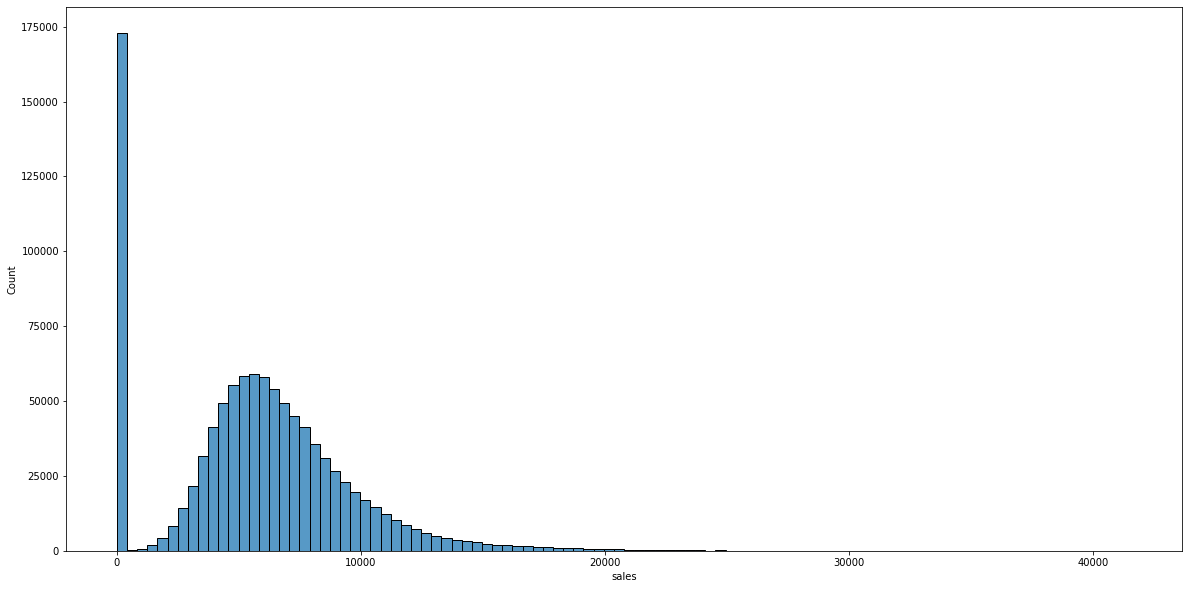

In [35]:
# sales
# Many records involve days with 0 sales (do not offer information, must be filtered later)
sns.histplot( df2['sales'], bins=100 );

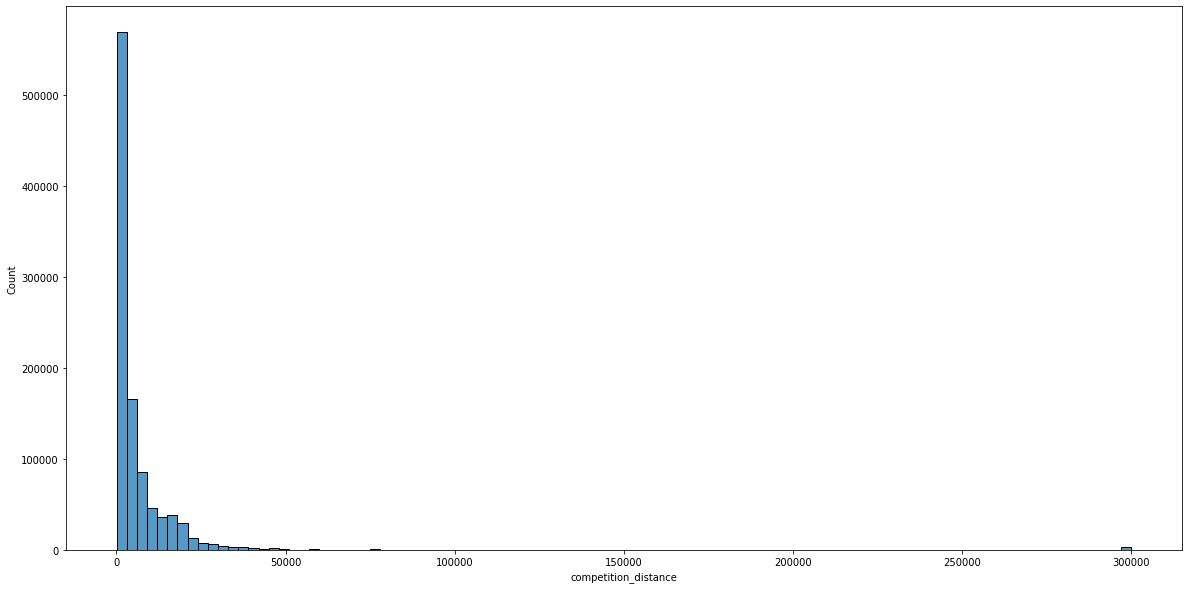

In [36]:
# competition_distance
sns.histplot( df2['competition_distance'], bins=100 );

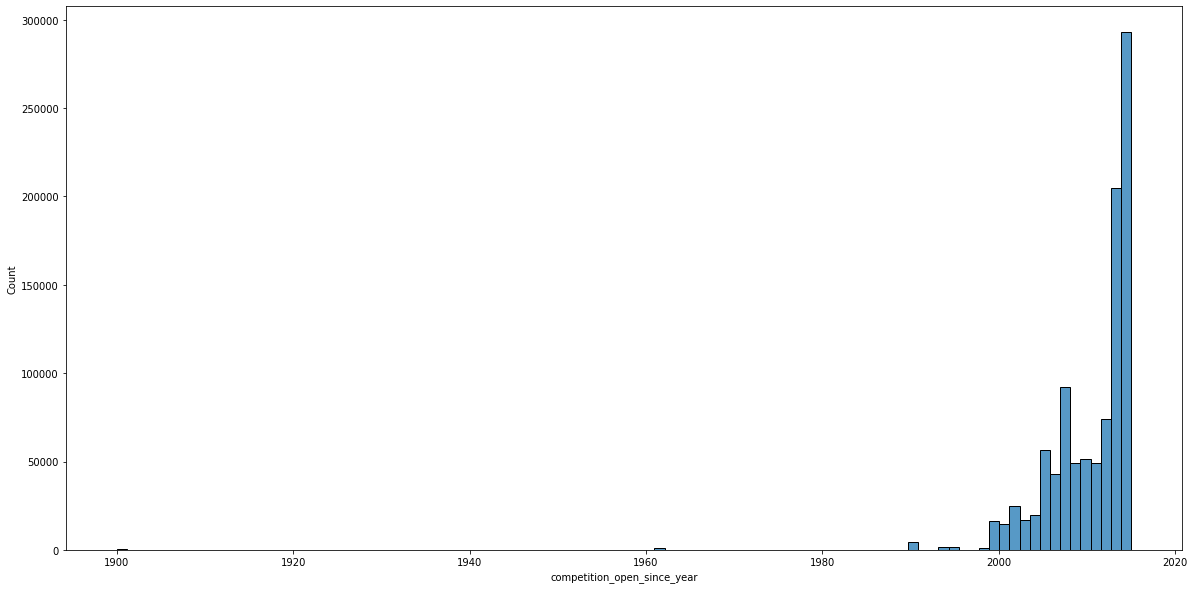

In [37]:
# competition_open_since_year
# Despite the 1900 minimum being highly unusual, it is not impossible at all 
sns.histplot( df2['competition_open_since_year'], bins=100 );

In [38]:
# It occurs for only two stores
df2.loc[(df2.loc[:,'competition_open_since_year'] < 1990),['store','competition_open_since_year']].drop_duplicates( 'store' )

,store,competition_open_since_year
145,146,1961
814,815,1900


### Categorial attributes

In [39]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

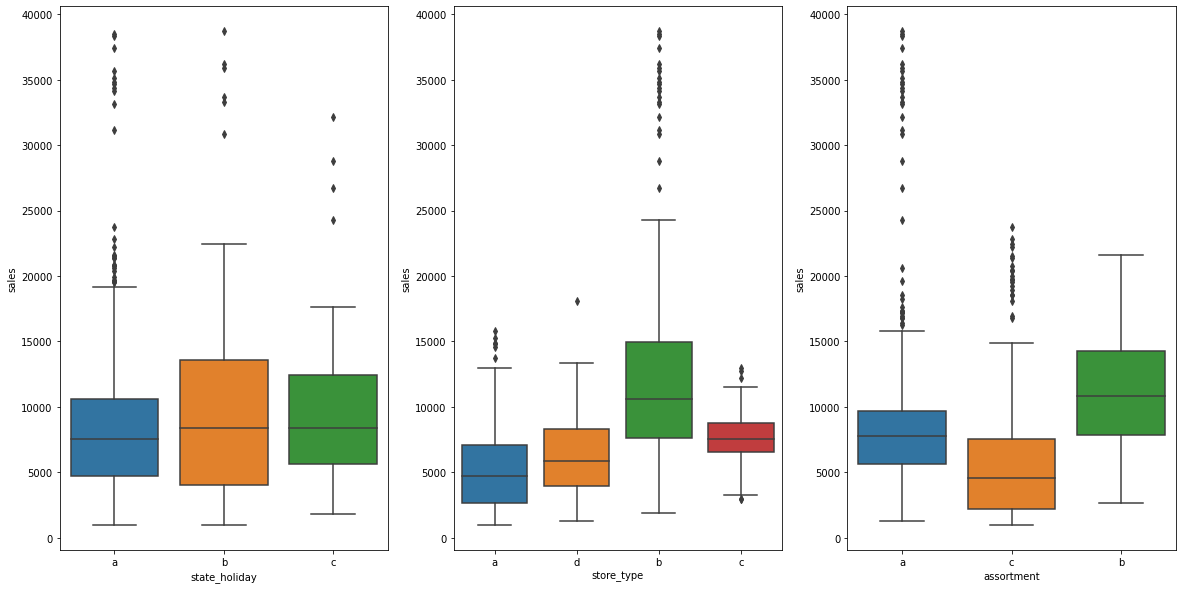

In [40]:
# Excluding normal days (not holidays) e days with 0 sales
aux1 = df2.loc[( df2['state_holiday'] != '0' ) & ( df2['sales'] > 0 ),:]

plt.subplot(1, 3, 1);
sns.boxplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot(1, 3, 2);
sns.boxplot( x='store_type', y='sales', data=aux1 );

plt.subplot(1, 3, 3);
sns.boxplot( x='assortment', y='sales', data=aux1 );

# FEATURE ENGINEERING

**Business hypotheses** *from mind map of the problem with its agents and influencing factors*

In [41]:
df3 = df2.copy()

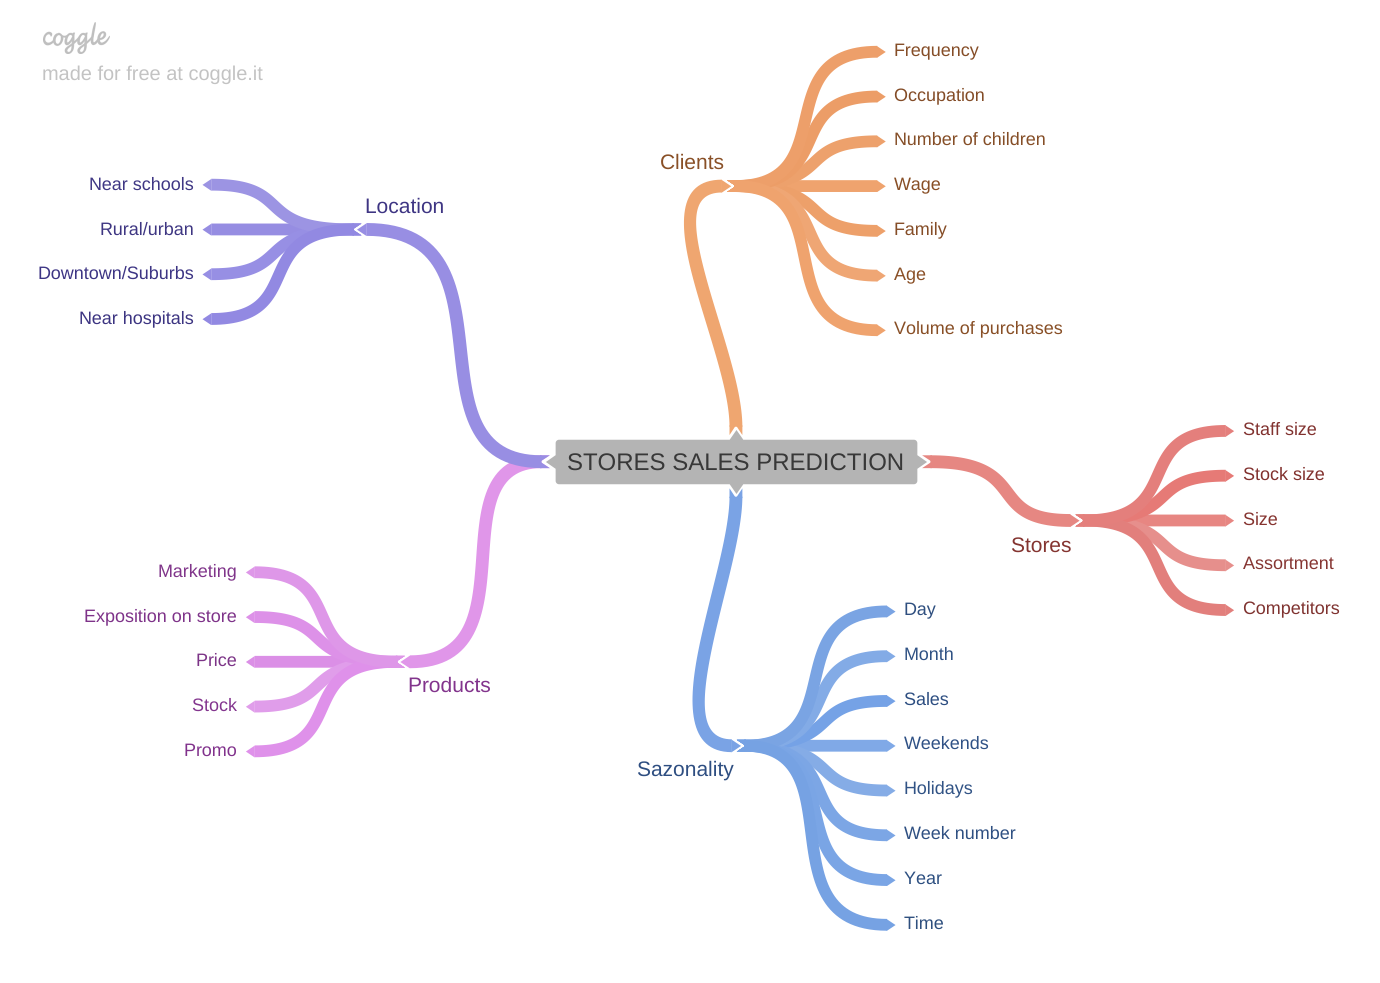

In [42]:
Image( '../imgs/STORES_SALES_PREDICTION.png', width=900 )

## Creation of hypotheses

### Stores

**Greater income if:**

**1.** Bigger staff size

**2.** Bigger stock size 

**3.** Larger stores

**4.** Greater assortment

**5.** Older competitors

**Smaller income if:**

**6.** Closer competitors

### Products

**Greater income if:**

**1.** Greater marketing investment 

**2.** Better exposition at store 

**3.** Lower prices 

**4.** More aggressive sales

**5.** Joined the extended promo (promo 2) longer ago

**6.** More promo days

**7.** More consecutive promos

### Sazonality

**Smaller income during:**

**1.** School holidays

**2.** Weekends
     
**Greater income:**

**3.** If open during Christmas 

**4.** Along the passage of years

**5.** On the second semester of each year

**6.** After the 10th day of each month

## Final list of hypotheses
*Selecting only the ones currently feasible*

*Remaining ones postponed for future cycles (CRISP-DM)*

**1.** Greater assortment 🠒 bigger income

**2.** Older competitors 🠒 bigger income

**3.** Closer competitors 🠒 lower income

**4.** Adhesion to the extended promo (promo 2) longer ago 🠒 bigger income

**5.** More promo days 🠒 bigger income

**6.** More consecutive sales 🠒 bigger income

**7.** On school holidays 🠒 lower income

**8.** On weekends 🠒 lower income

**9.** If open during Christmas 🠒 bigger income

**10.** Along the passage of years 🠒 bigger income

**11.** On the second semester of each year 🠒 bigger income

**12.** After the 10th day of each month 🠒 bigger income

## Feature engineering

In [43]:
# year
df3['year'] = df3['date'].dt.year

# month
df3['month'] = df3['date'].dt.month

# day
df3['day'] = df3['date'].dt.day

# week of year
df3['week_of_year'] = df3['date'].dt.isocalendar().week - 1 # Minus 1 since ISO count starts from 1
df3['week_of_year'] = df3['week_of_year'].astype( np.int64 ) #UInt32 to int64

# year week
df3['year_week'] = df3['date'].dt.strftime( '%Y-%W' )

# competition since
df3['competition_since'] = df3.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
# competition time (months)
df3['competition_time_month'] = ( ( df3['date'] - df3['competition_since'] )/30 ).dt.days

# promo2 since
df3['promo2_since'] = df3['promo2_since_year'].astype(str) + '-' + df3['promo2_since_week'].astype(str)
df3['promo2_since'] = df3['promo2_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) )
# promo2 time (weeks)
df3['promo2_time_week'] = ( ( df3['date'] - df3['promo2_since'] )/7 ).dt.days

# assortment
df3['assortment'] = df3['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended' )

# state holiday
df3['state_holiday'] = df3['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# FILTERING VARIABLES

*Ruling out a subset of the data due to business restrictions*

In [44]:
df4 = df3.copy()

In [45]:
df4.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## Filtering rows

In [46]:
# Information about closed stores is not actually useful here 
df4 = df4.loc[(df4['open'] != 0)]

In [47]:
# Of these, very few records have 0 sales
df4.loc[df4['sales'] == 0].shape[0] / df4.shape[0]

6.395134013586107e-05

In [48]:
# They do not offer much information, so let's drop them
df4 = df4.loc[df4['sales'] > 0]

## Selecting columns

In [49]:
# 'Customers' won't be available for prediction
# Remaining were filtered/substituted
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df4 = df4.drop( columns=cols_drop )

In [50]:
df4.sample()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_start_promo2,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week
530258,304,4,2014-03-13,6688,0,regular_day,0,a,basic,1950.0,7,2015,0,11,2014,0,2014,3,13,10,2014-10,2015-07-01,-16,2014-03-17,-1


# EDA

In [51]:
df5 = df4.copy()

## Univariate analysis

In [52]:
# Update num/cat separation after filtering variables
num_attributes = df5.select_dtypes( include=['int64','float64'] )
cat_attributes = df5[['assortment','store_type','state_holiday', 'promo', 'school_holiday', 'promo2', 'is_start_promo2']].copy()

# Columns to reassign
cols = ['promo', 'school_holiday', 'promo2', 'is_start_promo2']
num_attributes = num_attributes.drop( columns=cols )

### Response variable

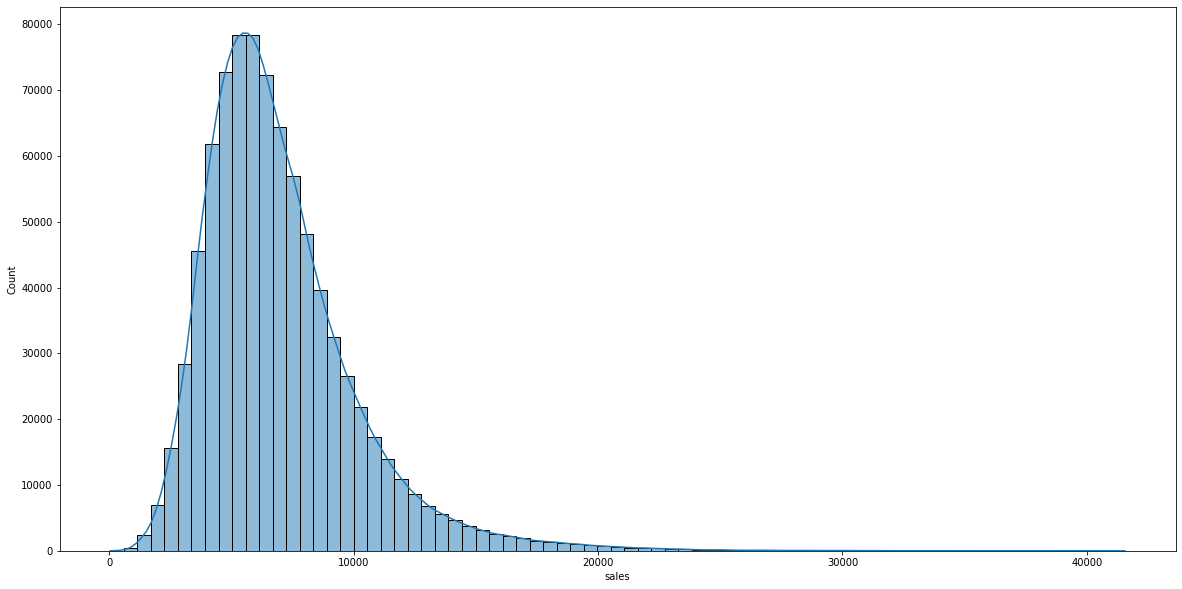

In [53]:
sns.histplot( df5['sales'], bins=75, kde=True );

### Numerical variables

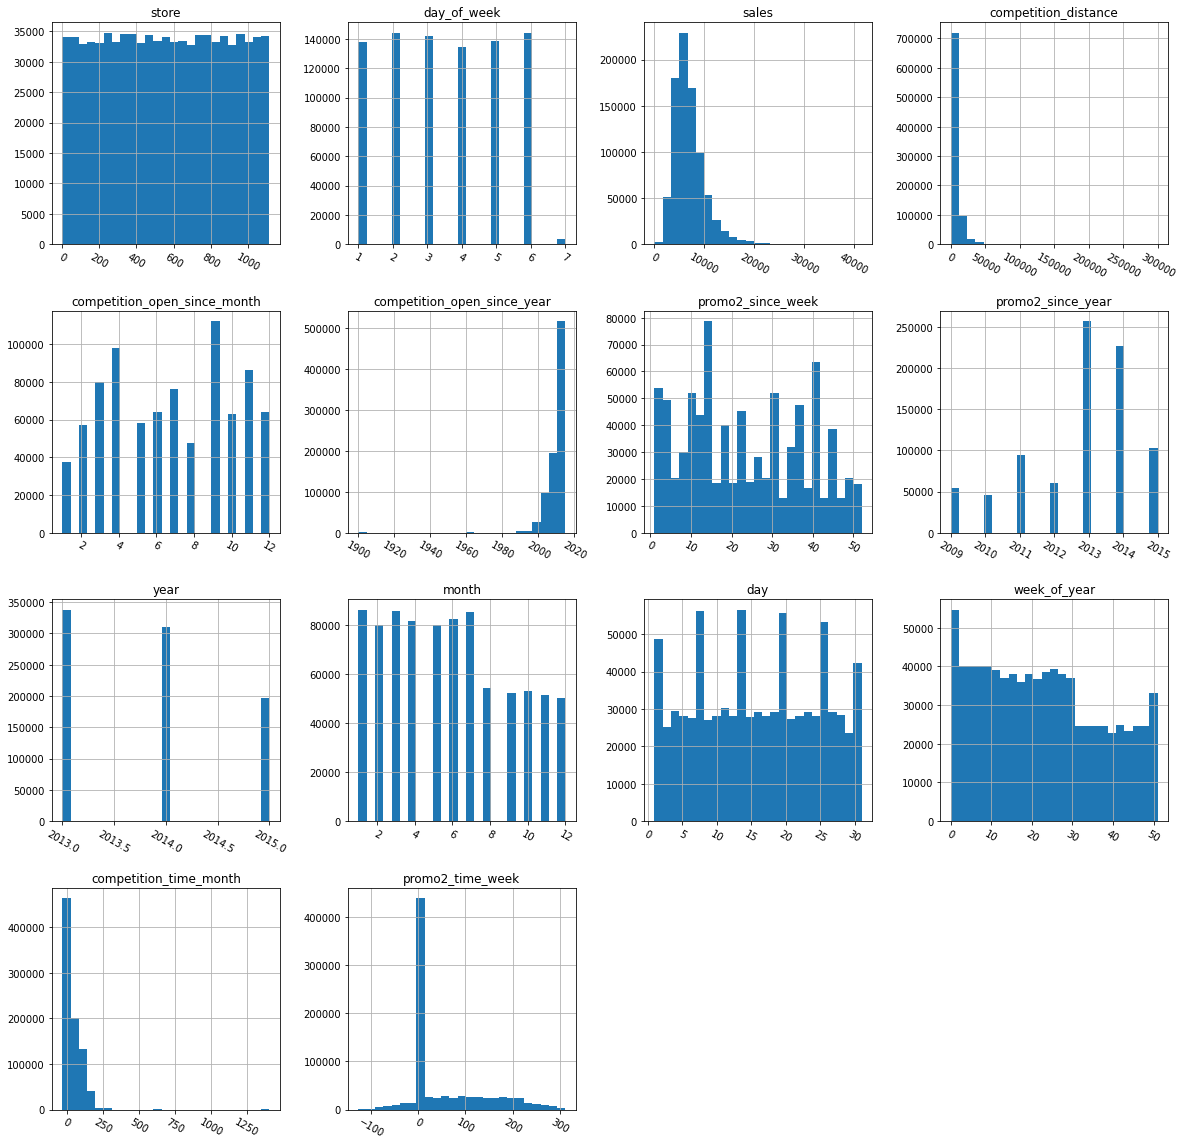

In [54]:
plt.rcParams['figure.figsize'] = 20,20
num_attributes.hist( bins=25, xrot=-30 );

_Enhancing and exploring some plots_

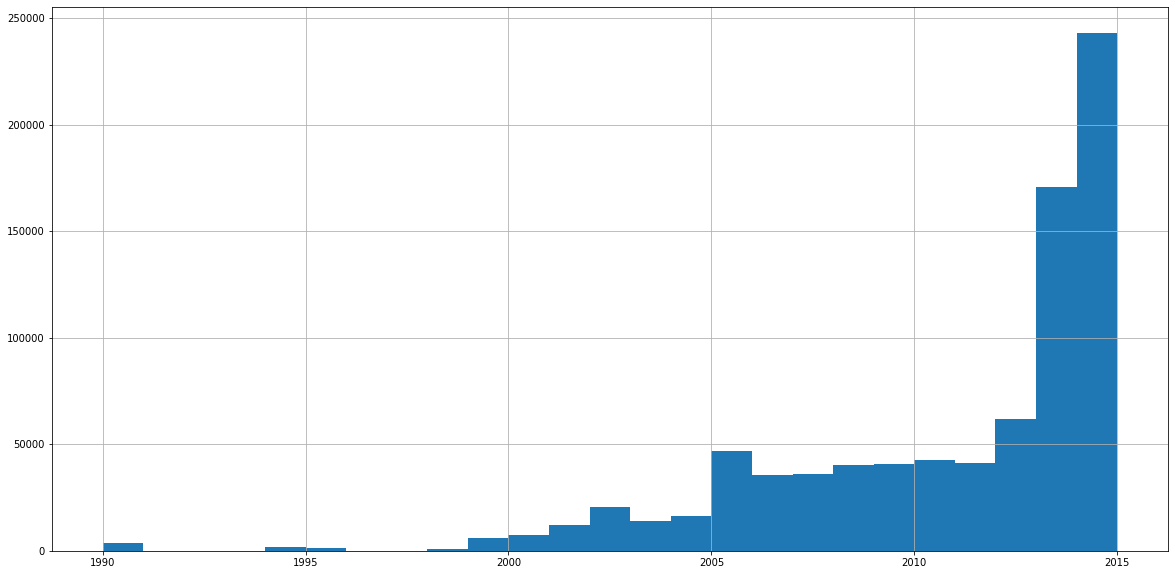

In [55]:
# promo2_since_year -> spikes since 2013 are due to the earlier NA filling procedure
# Same happens with competition_open_since_year (filtering outlier)
plt.rcParams['figure.figsize'] = 20,10
num_attributes.loc[num_attributes['competition_open_since_year'] >= 1990, 'competition_open_since_year'].hist( bins=25 );

In [56]:
# year, month and week_of_year histograms behavior is due to smaller date range in 2015

print(
    f"First date in 2015: {df5.loc[df5['year'] == 2015, 'date'].min()} \n"
    f"Last date in 2015: {df5.loc[df5['year'] == 2015, 'date'].max()}"
)

First date in 2015: 2015-01-01 00:00:00 
Last date in 2015: 2015-07-31 00:00:00


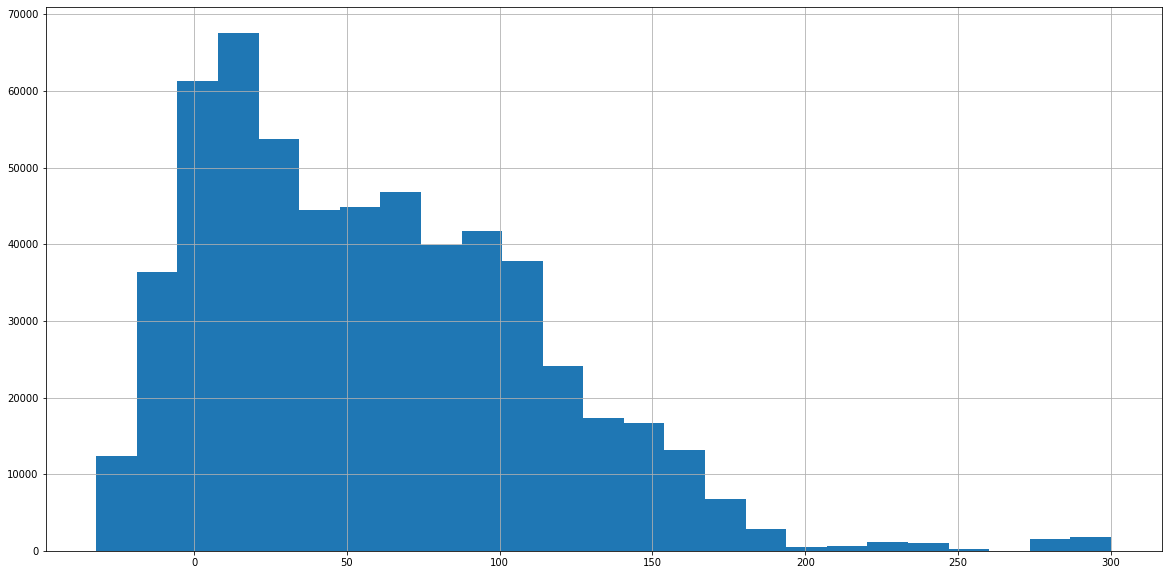

In [57]:
# competition_time_month -> many null values were due to the earlier NA filling procedure
#                           very high values are due to outliers (competition_open_since < 1990)
num_attributes.loc[(num_attributes['competition_time_month'] != 0) & (num_attributes['competition_time_month'] <= 300), 'competition_time_month'].hist( bins=25 );

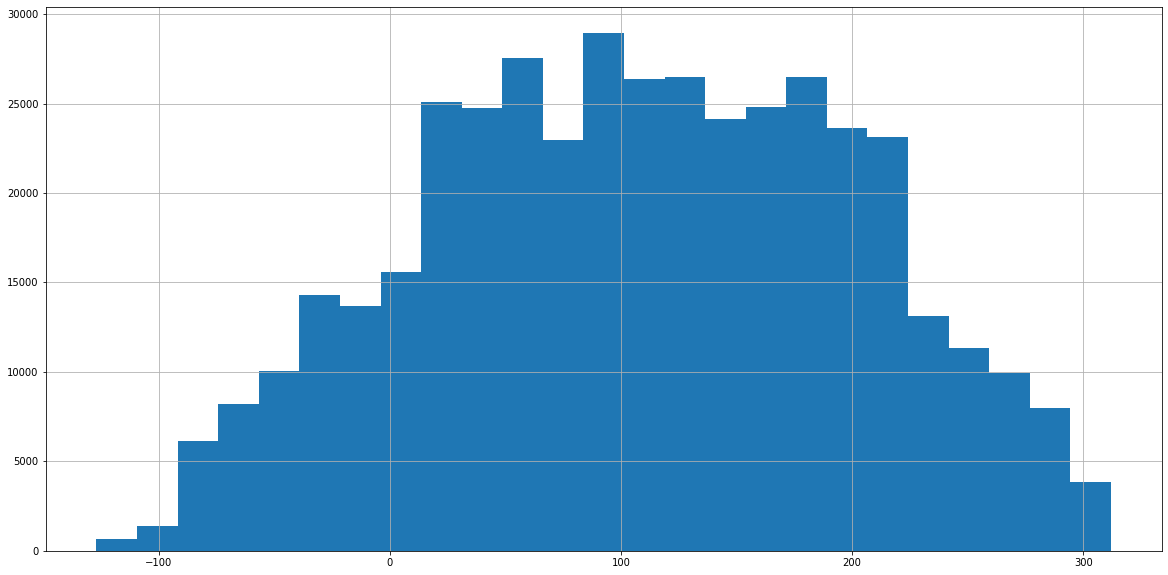

In [58]:
# promo2_time_week -> null and unitary values were due to earlier NA filling procedure
num_attributes.loc[abs( num_attributes['promo2_time_week'] ) > 1, 'promo2_time_week'].hist( bins=25 );

### Categorical variables

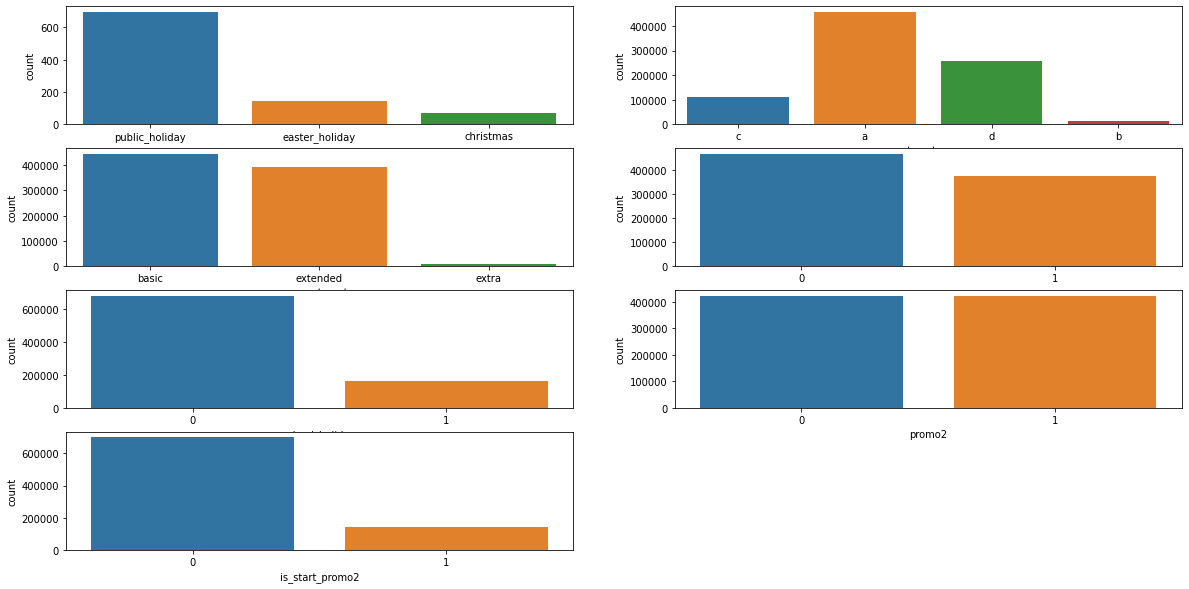

In [59]:
# state_holiday
aux = cat_attributes[cat_attributes['state_holiday'] != 'regular_day'] # regular days compose the bulk, making visualization harder
plt.subplot( 4, 2, 1 )
sns.countplot( x=aux['state_holiday'] );

# store_type
plt.subplot( 4, 2, 2 )
sns.countplot( x=cat_attributes['store_type'] );

# assortment
plt.subplot( 4, 2, 3 )
sns.countplot( x=cat_attributes['assortment'] );

# promo
plt.subplot( 4, 2, 4 )
sns.countplot( x=cat_attributes['promo'] );

# school_holiday
plt.subplot( 4, 2, 5 )
sns.countplot( x=cat_attributes['school_holiday'] );

# promo2
plt.subplot( 4, 2, 6 )
sns.countplot( x=cat_attributes['promo2'] );

# is_start_promo2
plt.subplot( 4, 2, 7 )
sns.countplot( x=cat_attributes['is_start_promo2'] );

## Bivariate analysis
*Validating the hypotheses raised earlier*

_**Summary**_

In [60]:
tab = [['Hypothesis', 'Conclusion', 'Correlation with target'],
      ['1','True','High'],
      ['2','True','Low'],
      ['3','False','Very low'],
      ['4','True','Low'],
      ['5','-','-'],
      ['6','False','High'],
      ['7','False','Medium'],
      ['8','True','Very low'],
      ['9','True','High'],
      ['10','True','Very low'],
      ['11','True','Medium'],
      ['12','False','Medium']]

print( tabulate( tab, headers='firstrow' ) )

  Hypothesis  Conclusion    Correlation with target
------------  ------------  -------------------------
           1  True          High
           2  True          Low
           3  False         Very low
           4  True          Low
           5  -             -
           6  False         High
           7  False         Medium
           8  True          Very low
           9  True          High
          10  True          Very low
          11  True          Medium
          12  False         Medium


### Store with greater assortment 🠒 bigger income
_**<span style='color:red'>True:</span>**_ stores with more ('extra') assortment sell more _in average_, even though the difference is only slight. Moreover, they sell less _in total_; makes sense, since these stores are "rarer" (see Univariate analysis).

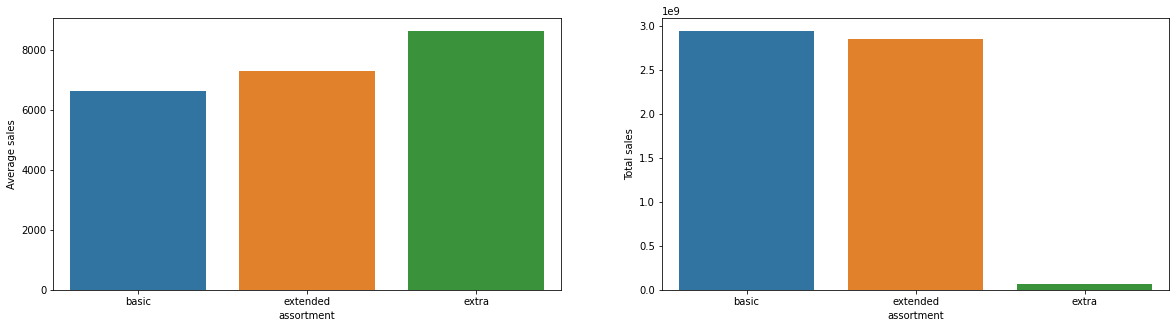

In [61]:
plt.rcParams['figure.figsize'] = 20,5

plt.subplot( 1,2,1 )
aux1 = df5[['assortment', 'sales']].groupby( 'assortment' ).mean().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );
plt.ylabel( 'Average sales' );

plt.subplot( 1,2,2 )
aux2 = df5[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux2 );
plt.ylabel( 'Total sales' );

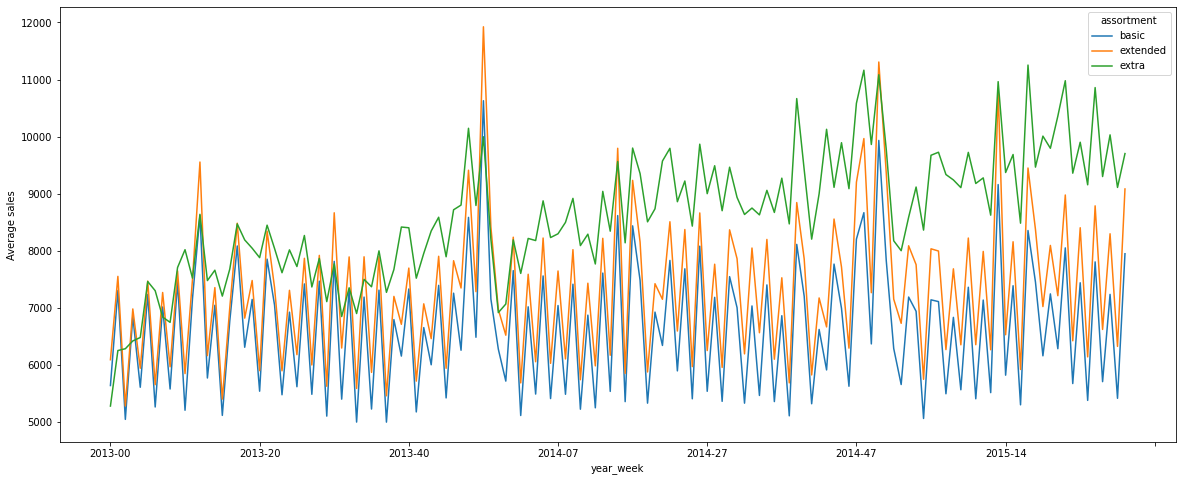

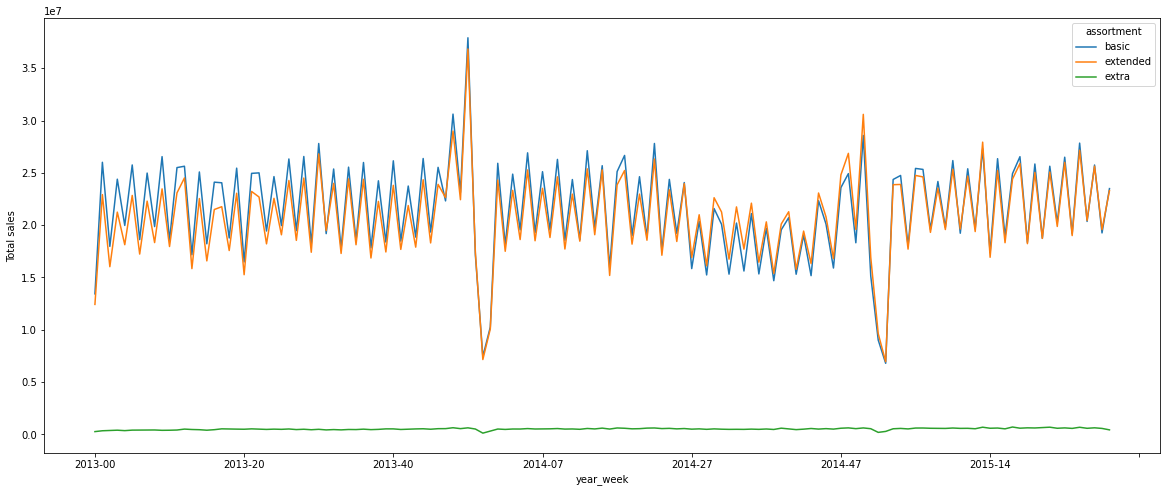

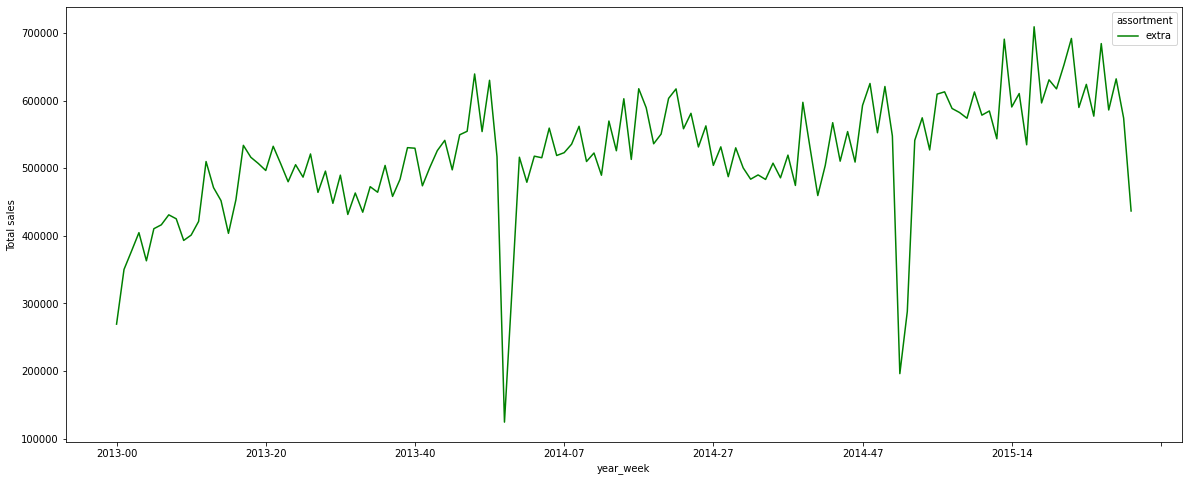

In [62]:
# Is this behavior consistent over time?

plt.rcParams['figure.figsize'] = 20,8

aux3 = df5[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).mean().reset_index()
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();
plt.ylabel( 'Average sales' );

aux4 = df5[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux4.pivot( index='year_week', columns='assortment', values='sales' ).plot();
plt.ylabel( 'Total sales' );

aux5 = aux4[aux4['assortment'] == 'extra']
aux5.pivot( index='year_week', columns='assortment', values='sales' ).plot( color='g' );
plt.ylabel( 'Total sales' );

#### Statistical analysis

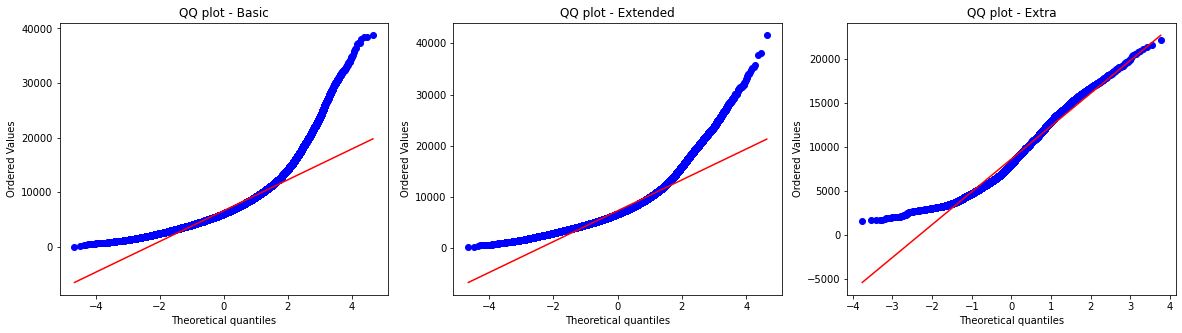

In [63]:
# Sales for each level of "assortment" are not sufficiently close to normal in order to apply ANOVA 

plt.rcParams['figure.figsize'] = 20,5

plt.subplot( 1,3,1 )
stats.probplot( df5.loc[df5['assortment'] == 'basic', 'sales'], dist='norm', plot=plt );
plt.title( 'QQ plot - Basic' );

plt.subplot( 1,3,2 )
stats.probplot( df5.loc[df5['assortment'] == 'extended', 'sales'], dist='norm', plot=plt );
plt.title( 'QQ plot - Extended' );

plt.subplot( 1,3,3 )
stats.probplot( df5.loc[df5['assortment'] == 'extra', 'sales'], dist='norm', plot=plt );
plt.title( 'QQ plot - Extra' );

plt.rcParams['figure.figsize'] = 20,10

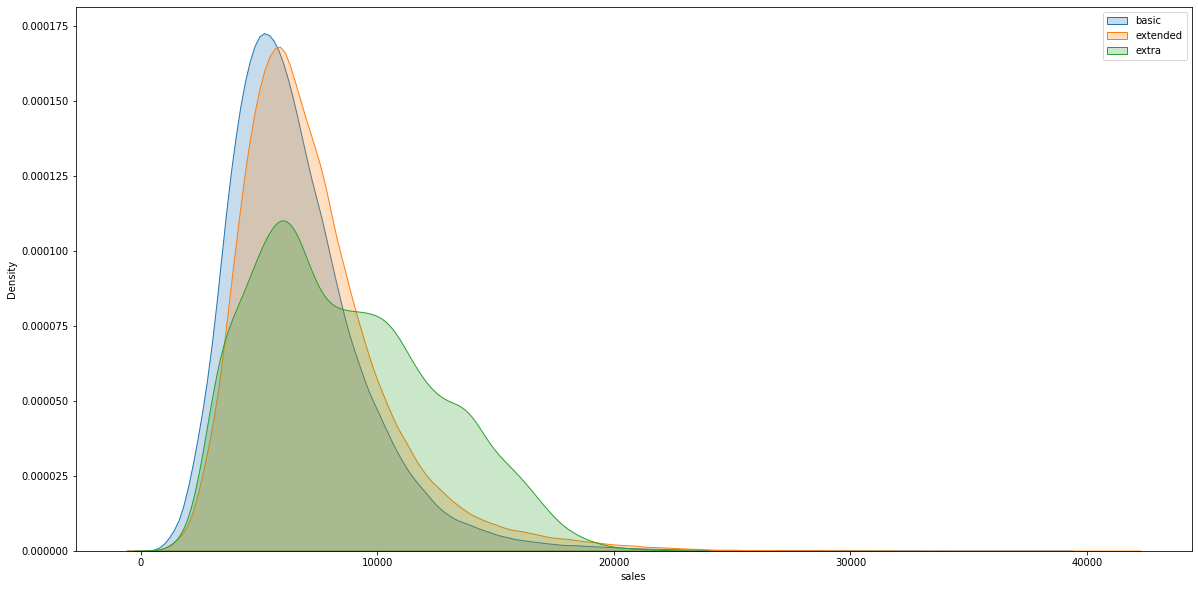

In [64]:
# Checking distributions shapes for Kruskal-Wallis test (below)

sns.kdeplot( df5[df5['assortment'] == 'basic']['sales'], label='basic', shade=True );
sns.kdeplot( df5[df5['assortment'] == 'extended']['sales'], label='extended', shade=True );
sns.kdeplot( df5[df5['assortment'] == 'extra']['sales'], label='extra', shade=True );
plt.legend();

In [65]:
# Kruskal-Wallis test ("non-parametric ANOVA")

stats.kruskal( df5.loc[df5['assortment'] == 'basic', 'sales'], 
               df5.loc[df5['assortment'] == 'extended', 'sales'], 
               df5.loc[df5['assortment'] == 'extra', 'sales'] )

# H0 rejected for distributions w/ different shapes 
#    → mean ranks are significantly different

KruskalResult(statistic=13268.894501874209, pvalue=0.0)

In [66]:
# Post-hoc Dunn's test
sp.posthoc_dunn( df5, 'sales', 'assortment' )

# Mean ranks significantly different pairwise

,basic,extended,extra
basic,1.0,0.000000e+00,0.000000e+00
extended,0.0,1.000000e+00,1.357244e-195
extra,0.0,1.357244e-195,1.000000e+00


### Stores with older competitors 🠒 bigger income
_**<span style='color:red'>True:</span>**_ stores with older competitors indeed sell slightly more.

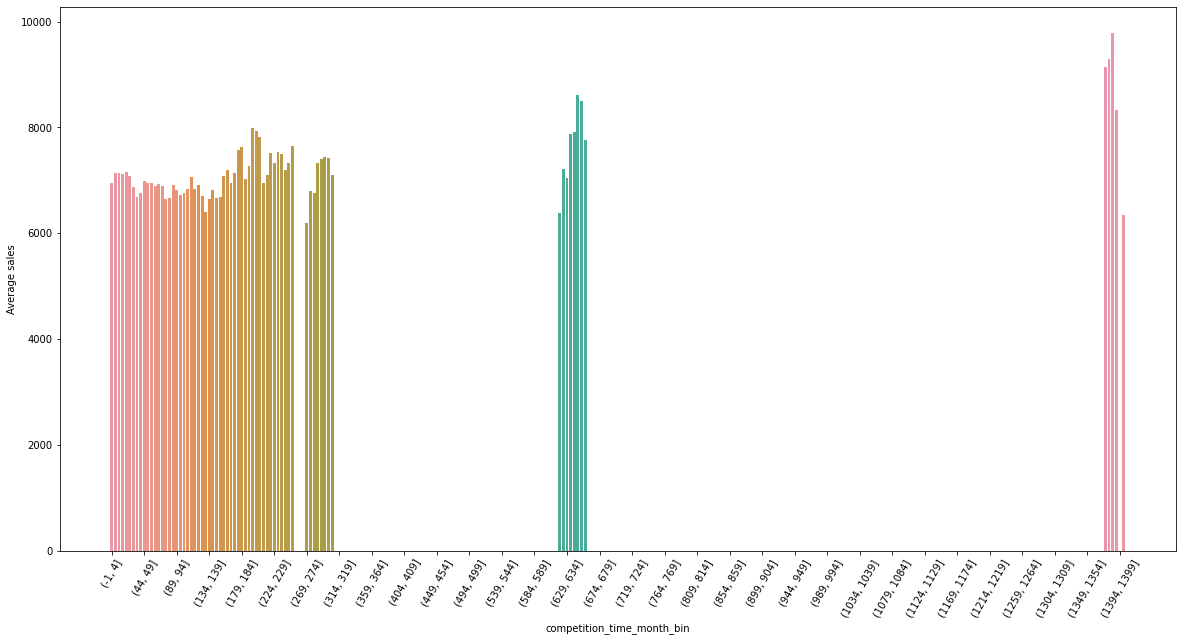

In [67]:
# Filtering out information too far in the future about competition
aux1 = df5.loc[df5.loc[:,'competition_time_month'] >= -1,['competition_time_month','sales']]

bins = np.arange( aux1.loc[:,'competition_time_month'].min(), aux1.loc[:,'competition_time_month'].max(), 5 )
aux1.loc[:,'competition_time_month_bin'] = pd.cut( aux1.loc[:,'competition_time_month'], bins=bins )

aux2 = aux1.groupby( 'competition_time_month_bin' ).mean().reset_index()

sns.barplot( x='competition_time_month_bin', y='sales', data=aux2 );
plt.locator_params( axis='x', nbins=35 )
plt.xticks( rotation=60 );
plt.ylabel( 'Average sales' );

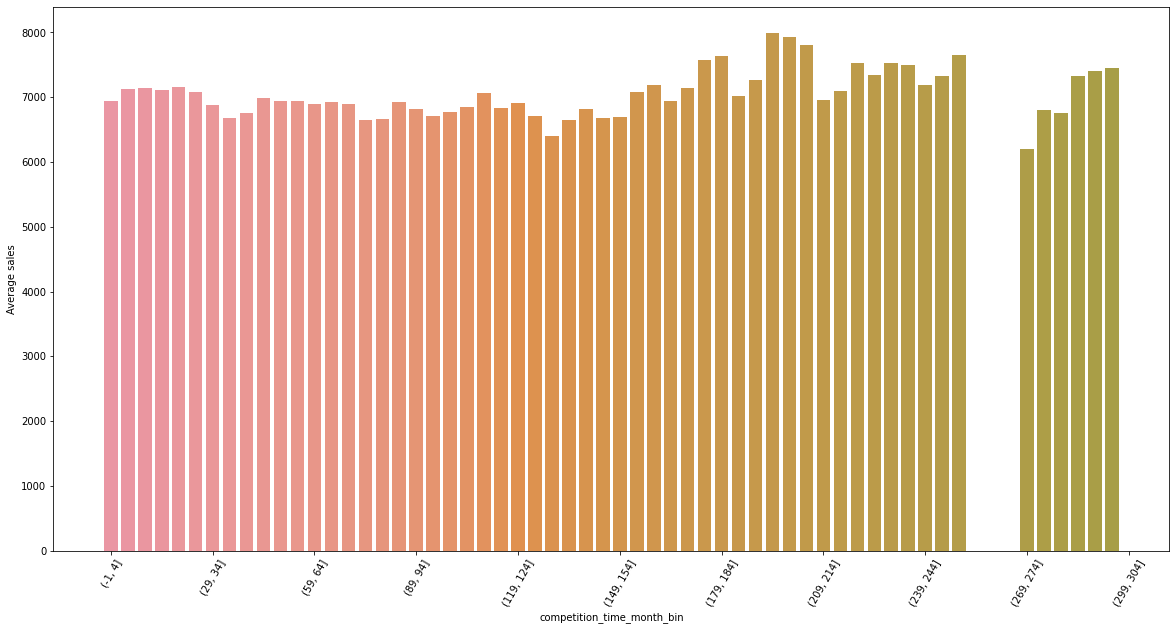

In [68]:
# Only 2 stores present competition_time_month >= 300 (see Univ. analysis), so filtering them out gives

aux3 = aux2[aux2['competition_time_month'] < 300]
sns.barplot( x='competition_time_month_bin', y='sales', data=aux3 );
plt.locator_params( axis='x', nbins=55 )
plt.xticks( rotation=60 );
plt.ylabel( 'Average sales' );

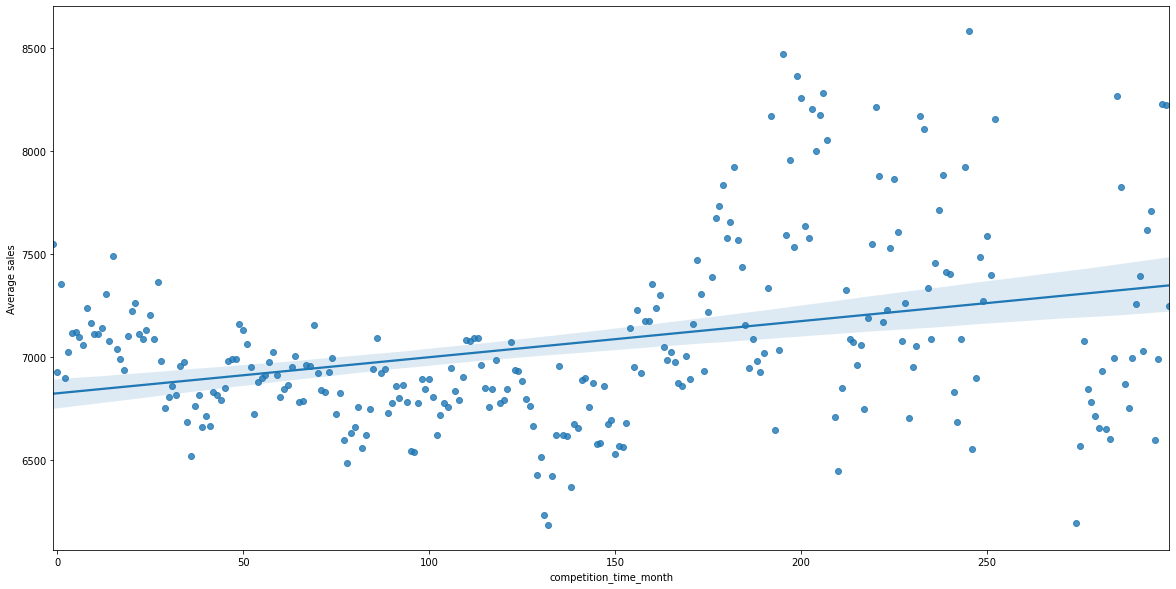

In [69]:
# Still keeping out the two outliers
aux4 = df5.loc[(df5['competition_time_month'] >= -1) & (df5['competition_time_month'] < 300),['competition_time_month','sales']].groupby( 'competition_time_month' ).mean().reset_index()

sns.regplot( x='competition_time_month', y='sales', data=aux4 );
plt.ylabel( 'Average sales' );

In [70]:
# Hypothesis testing

stats.pearsonr( aux4['competition_time_month'], aux4['sales'] )

(0.33742935100181687, 7.411805962819546e-09)

In [71]:
# Feature importance for modeling

stats.pearsonr( df5['competition_time_month'], df5['sales'] )

(-0.0035707813312442155, 0.0010339560383284014)

In [72]:
# Linear behavior of data is not so visually remarkable
# Testing Kendall's tau over Pearson's r

In [73]:
# Hypothesis testing

stats.kendalltau( aux4['competition_time_month'], aux4['sales'] )

# 0.16 -> "positive monotonicity prevails over negative one"

KendalltauResult(correlation=0.15829916711791858, pvalue=8.099307140288944e-05)

In [74]:
# Feature importance for modeling

stats.kendalltau( df5['competition_time_month'], df5['sales'] )

# -0.02 -> very small correlation

KendalltauResult(correlation=-0.01874084712163458, pvalue=2.1549270545596885e-136)

### Stores with closer competitors 🠒 lower income
_**<span style='color:red'>False:</span>**_ there is no remarkable correlation between the distance to competitors and sales.

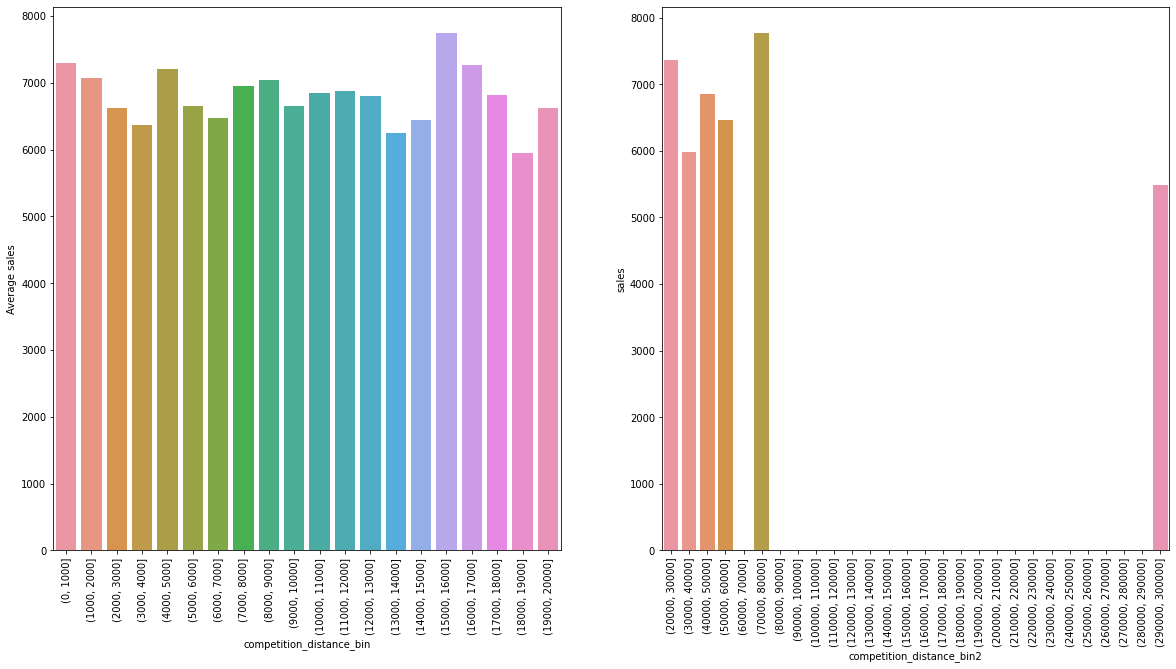

In [75]:
aux1 = df5.loc[:,['competition_distance','sales']]

bins = np.arange( 0, 20001, 1000 )
aux1['competition_distance_bin'] = pd.cut(aux1.loc[:,'competition_distance'], bins=bins)

aux2 = aux1.groupby( 'competition_distance_bin' ).mean().reset_index()

plt.subplot(1,2,1)
sns.barplot( x=aux2['competition_distance_bin'], y=aux2['sales'] );
plt.xticks( rotation=90 );
plt.ylabel( 'Average sales' );


bins = np.arange( 20000, 300001, 10000 )
aux1['competition_distance_bin2'] = pd.cut(aux1.loc[:,'competition_distance'], bins=bins)

aux3 = aux1.groupby( 'competition_distance_bin2' ).mean().reset_index()

plt.subplot(1,2,2)
sns.barplot( x=aux3['competition_distance_bin2'], y=aux3['sales'] );
plt.xticks( rotation=90 );

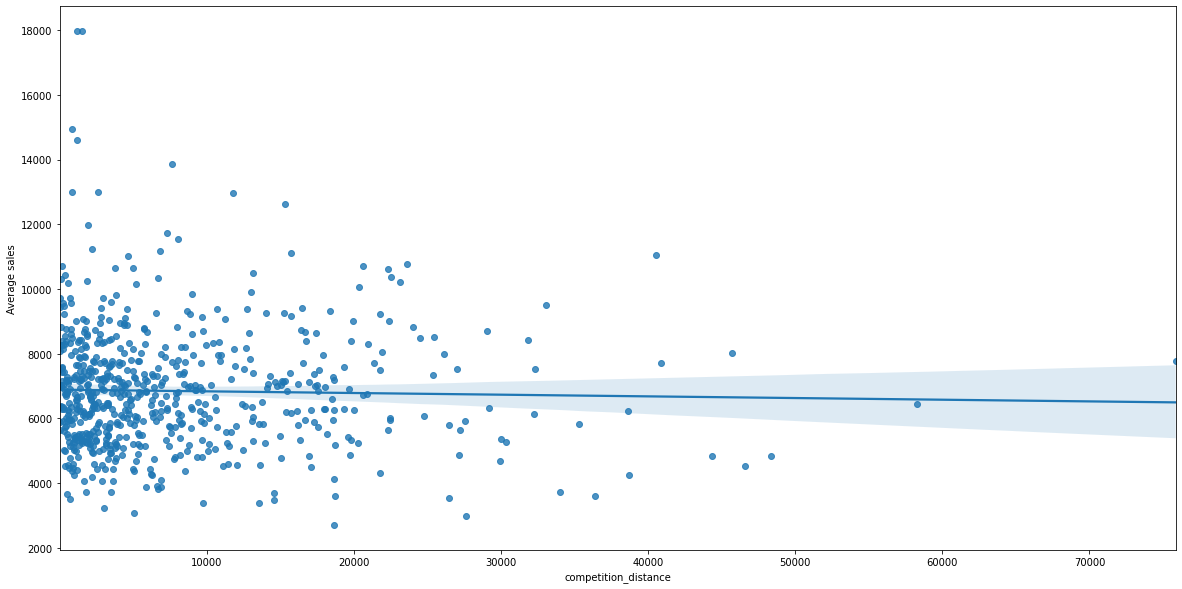

In [76]:
aux4 = aux1[aux1['competition_distance'] < 300000].groupby( 'competition_distance' ).mean().reset_index()

sns.regplot( x='competition_distance', y='sales', data=aux4 );
plt.ylabel( 'Average sales' );

In [77]:
# Regression plot does not depict linear behavior, nor monotonicity
# Kendall's tau is chosen over Pearson's r and Spearman's rho

In [78]:
# Hypothesis testing

stats.kendalltau( aux4['competition_distance'], aux4['sales'] )

# Not discernible from random pattern

KendalltauResult(correlation=-0.010354468437838065, pvalue=0.69200278061008)

In [79]:
# Feature importance for modeling

stats.kendalltau( df5['competition_distance'], df5['sales'] )

KendalltauResult(correlation=-0.02429753484367028, pvalue=2.7876442000029007e-245)

### Stores that joined the extended promo (promo 2) longer ago 🠒 bigger income
_**<span style="color:red">True:</span>**_ indeed, stores that joined promo 2 seem to perform better as time passes, even if it is only slightly.

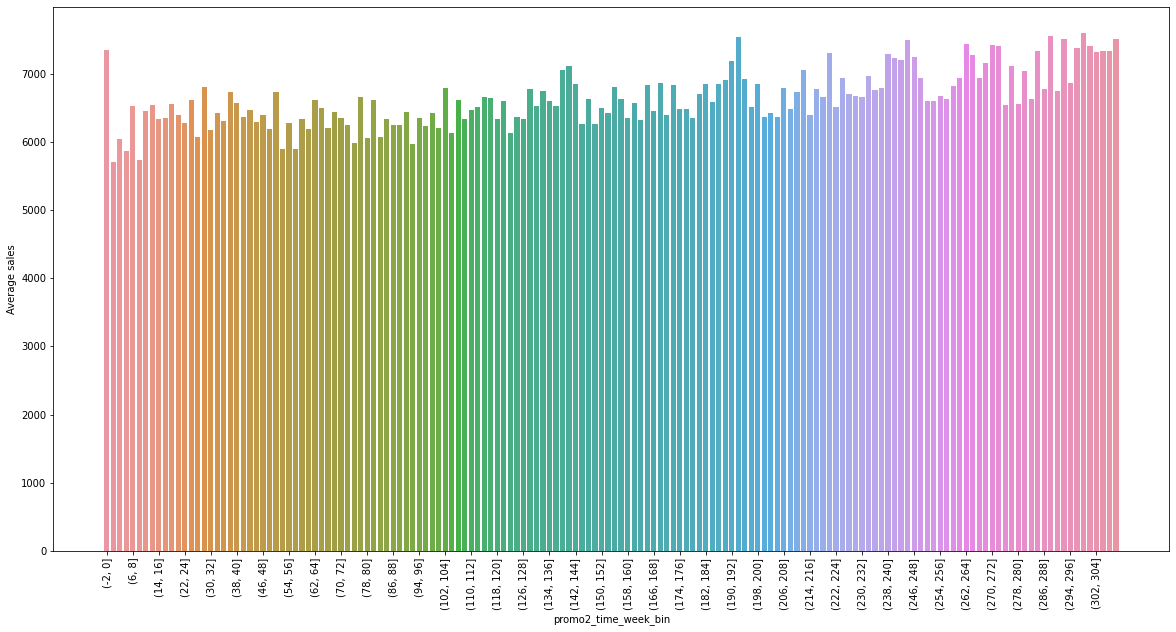

In [80]:
# Filtering out promos too far in the future
aux1 = df5.loc[df5.loc[:,'promo2_time_week'] >= -2, ['sales','promo2_time_week']]

# Binning for better visualisation
bins = np.arange( aux1.loc[:,'promo2_time_week'].min(), aux1.loc[:,'promo2_time_week'].max(), 2 )
aux1.loc[:,'promo2_time_week_bin'] = pd.cut( aux1.loc[:,'promo2_time_week'], bins=bins )

aux2 = aux1[['promo2_time_week_bin','sales']].groupby( 'promo2_time_week_bin' ).mean().reset_index()
sns.barplot( x='promo2_time_week_bin', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.locator_params( axis='x', nbins=40 )
plt.ylabel( 'Average sales' ); 

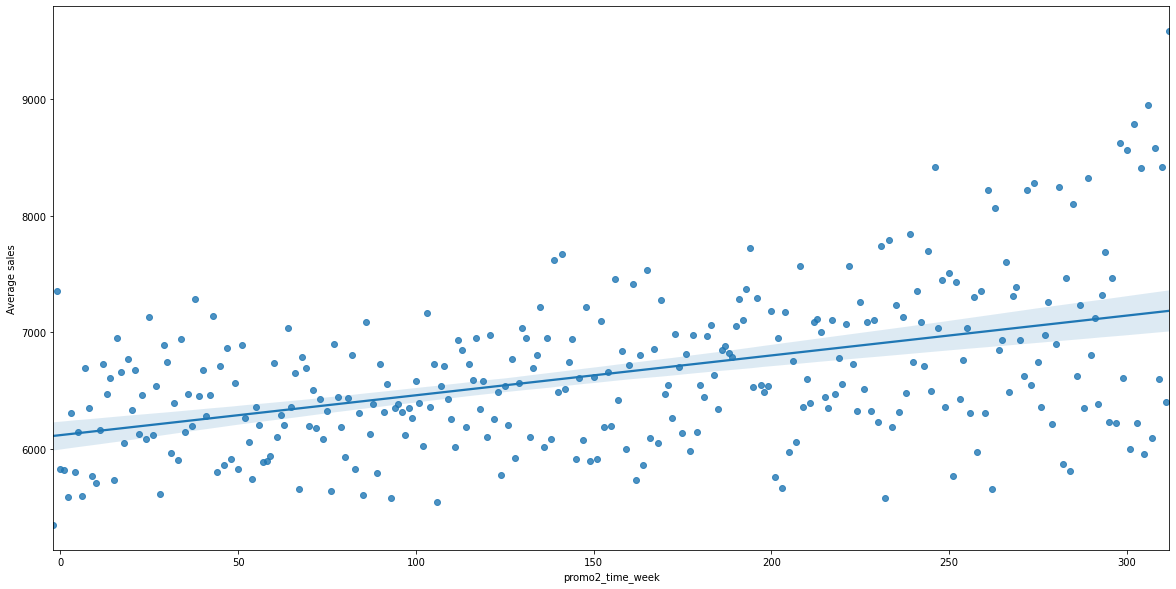

In [81]:
aux3 = df5.loc[df5.loc[:,'promo2_time_week'] >= -2, ['sales','promo2_time_week']].groupby( 'promo2_time_week' ).mean().reset_index()

sns.regplot( x='promo2_time_week', y='sales', data=aux3 );
plt.ylabel( 'Average sales' );

In [82]:
# Hypothesis testing

stats.pearsonr( aux3['promo2_time_week'], aux3['sales'] )

(0.4662551676600964, 2.088740304169e-18)

In [83]:
# Feature importance for modeling

stats.pearsonr( df5['promo2_time_week'], df5['sales'] )

(-0.05725744834344424, 0.0)

### <s>More promo days 🠒 bigger income</s>
_Left for a future CRISP-DM cycle, since it would require the engineering of more complex features._

### Extending promos 🠒 bigger income
_**<span style="color:red">False:</span>**_ in average, stores in Promo 2 sell less than the reference (be it only the traditional promo or no promo at all).

In [84]:
df5.loc[:,['promo','promo2','sales']].groupby( ['promo','promo2'] ).mean().reset_index().sort_values( 'sales', ascending=False )

,promo,promo2,sales
2,1,0,8618.452062
3,1,1,7836.672987
0,0,0,6328.187633
1,0,1,5529.566684


In [85]:
# Fixing a caveat in order to plot as a function of year_week

aux = df5.loc[:,['promo', 'promo2', 'year_week', 'sales']].copy()
aux['year_week'] = aux['year_week'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) )

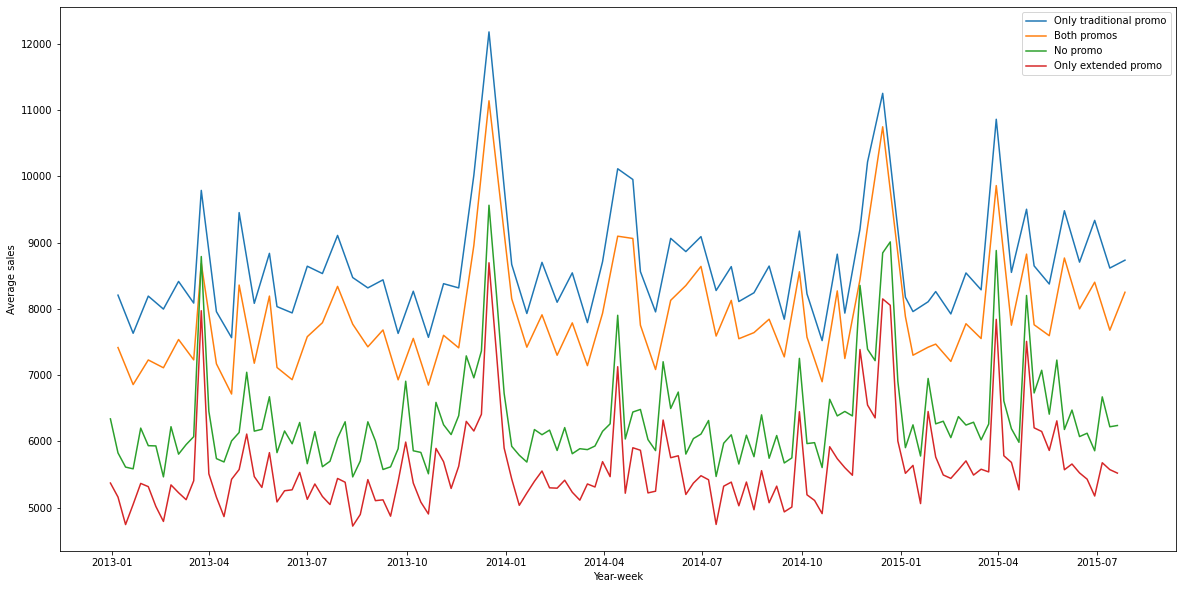

In [86]:
# Is the behavior above consistent over time?

aux1 = aux.loc[(aux['promo'] == 1) & (aux['promo2'] == 0),['year_week','sales']].groupby( 'year_week' ).mean().reset_index()
plt.plot( aux1['year_week'], aux1['sales'] );

aux2 = aux.loc[(aux['promo'] == 1) & (aux['promo2'] == 1),['year_week','sales']].groupby( 'year_week' ).mean().reset_index()
plt.plot( aux2['year_week'], aux2['sales'] );

aux3 = aux.loc[(aux['promo'] == 0) & (aux['promo2'] == 0),['year_week','sales']].groupby( 'year_week' ).mean().reset_index()
plt.plot( aux3['year_week'], aux3['sales'] );

aux4 = aux.loc[(aux['promo'] == 0) & (aux['promo2'] == 1),['year_week','sales']].groupby( 'year_week' ).mean().reset_index()
plt.plot( aux4['year_week'], aux4['sales'] );

plt.xlabel( 'Year-week' );
plt.ylabel( 'Average sales' );

plt.legend( labels=['Only traditional promo', 'Both promos', 'No promo', 'Only extended promo'] );

#### Statistical analysis

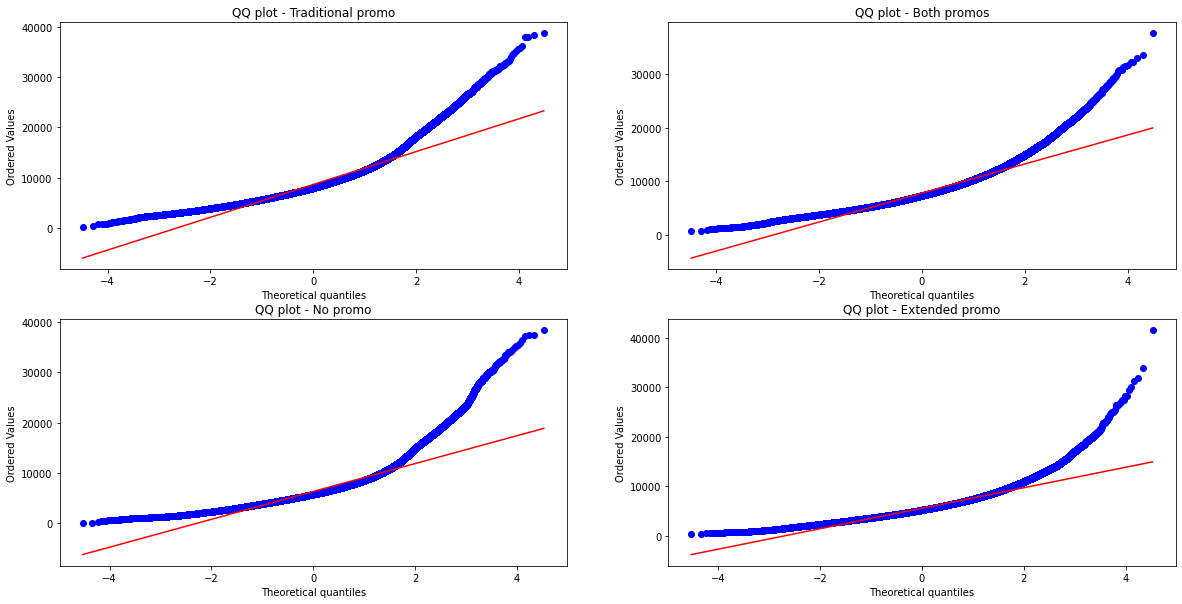

In [87]:
# Sales for each level are not sufficiently close to normal in order to apply ANOVA 

plt.subplot( 2,2,1 )
stats.probplot( df5.loc[(df5['promo'] == 1) & (df5['promo2'] == 0), 'sales'], dist='norm', plot=plt );
plt.title( 'QQ plot - Traditional promo' );

plt.subplot( 2,2,2 )
stats.probplot( df5.loc[(df5['promo'] == 1) & (df5['promo2'] == 1), 'sales'], dist='norm', plot=plt );
plt.title( 'QQ plot - Both promos' );

plt.subplot( 2,2,3 )
stats.probplot( df5.loc[(df5['promo'] == 0) & (df5['promo2'] == 0), 'sales'], dist='norm', plot=plt );
plt.title( 'QQ plot - No promo' );

plt.subplot( 2,2,4 )
stats.probplot( df5.loc[(df5['promo'] == 0) & (df5['promo2'] == 1), 'sales'], dist='norm', plot=plt );
plt.title( 'QQ plot - Extended promo' );

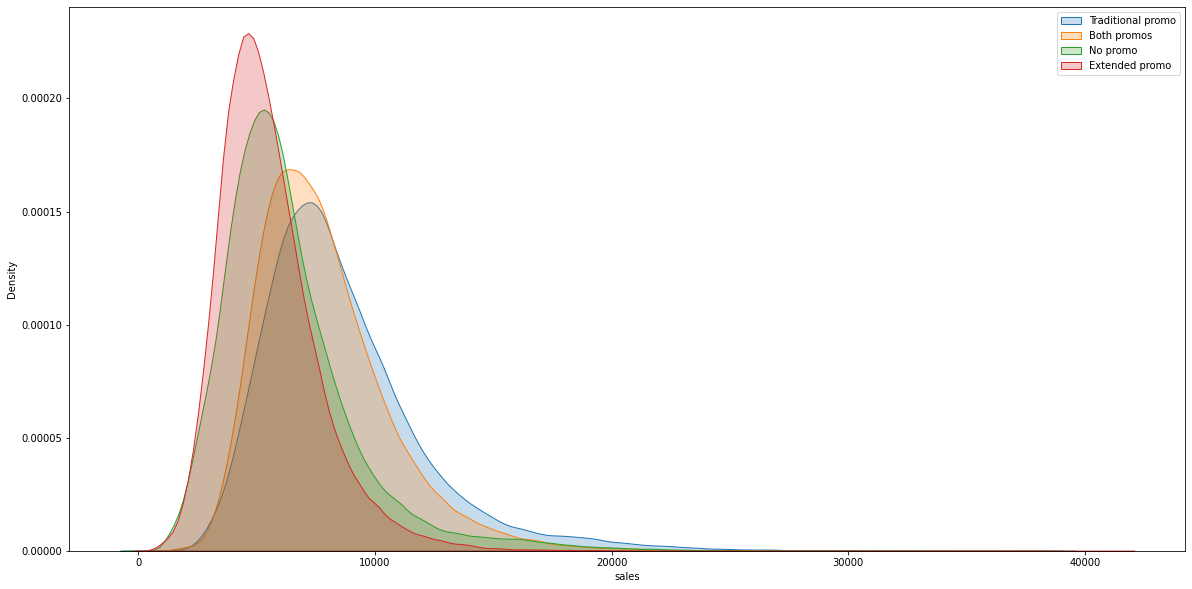

In [88]:
# Checking distributions shapes for Kruskal-Wallis test (below)

sns.kdeplot( df5[(df5['promo'] == 1) & (df5['promo2'] == 0)]['sales'], label='Traditional promo', shade=True );
sns.kdeplot( df5[(df5['promo'] == 1) & (df5['promo2'] == 1)]['sales'], label='Both promos', shade=True );
sns.kdeplot( df5[(df5['promo'] == 0) & (df5['promo2'] == 0)]['sales'], label='No promo', shade=True );
sns.kdeplot( df5[(df5['promo'] == 0) & (df5['promo2'] == 1)]['sales'], label='Extended promo', shade=True );
plt.legend();

# Similar shapes → test says about the medians

In [89]:
# Kruskal-Wallis test ("non-parametric ANOVA")

stats.kruskal( df5.loc[(df5['promo'] == 1) & (df5['promo2'] == 0), 'sales'], 
               df5.loc[(df5['promo'] == 1) & (df5['promo2'] == 1), 'sales'], 
               df5.loc[(df5['promo'] == 0) & (df5['promo2'] == 0), 'sales'],
               df5.loc[(df5['promo'] == 0) & (df5['promo2'] == 1), 'sales'] )

# H0 rejected → medians are significantly different

KruskalResult(statistic=161095.89411738518, pvalue=0.0)

In [90]:
# Post-hoc Dunn's test

aux = df5[['sales','promo','promo2']].copy()

aux['promos'] = aux.apply( lambda x: 'traditional' if (x['promo'] == 1) & (x['promo2'] == 0) else 
                                     'both' if (x['promo'] == 1) & (x['promo2'] == 1) else 
                                     'none' if (x['promo'] == 0) & (x['promo2'] == 0) else 
                                     'extended', axis=1 )

sp.posthoc_dunn( aux, 'sales', 'promos' )

# Medians significantly different pairwise

,both,extended,none,traditional
both,1.0,0.0,0.0,0.0
extended,0.0,1.0,0.0,0.0
none,0.0,0.0,1.0,0.0
traditional,0.0,0.0,0.0,1.0


### Stores open on school holidays 🠒 lower income
_**<span style="color:red">False:</span>**_ in average, stores sell slightly more during school holidays than not. This pattern repeats itself over most months of the year.

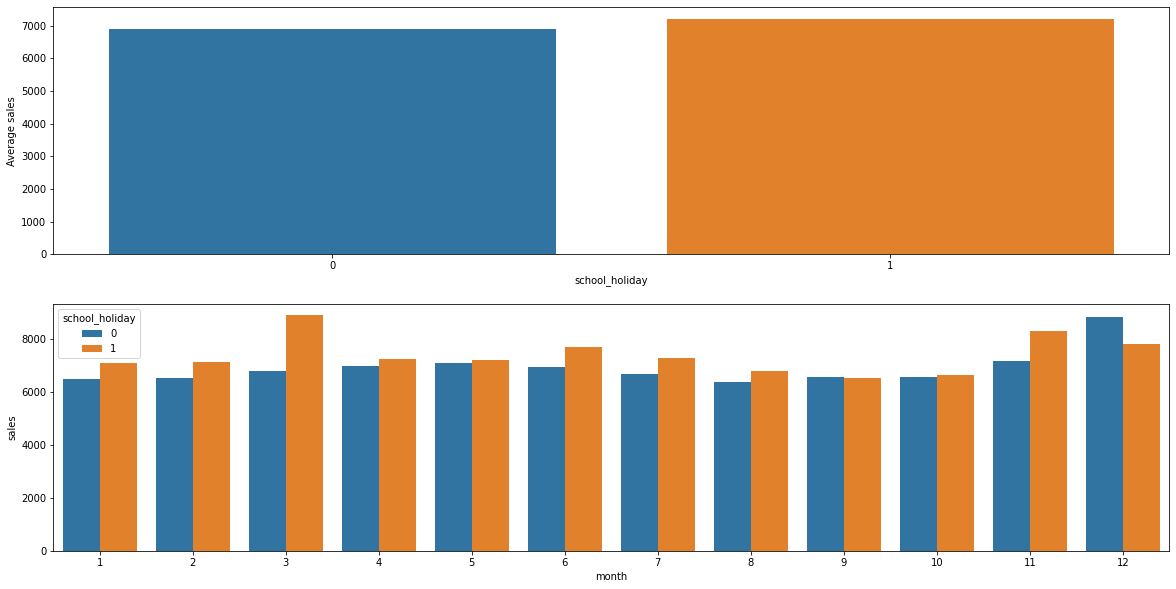

In [91]:
aux = df5.loc[:,['school_holiday', 'sales']].groupby( 'school_holiday' ).mean().reset_index()
plt.subplot( 2,1,1 )
sns.barplot( x='school_holiday', y='sales', data=aux );
plt.ylabel( 'Average sales' );


aux2 = df5.loc[:,['month','school_holiday', 'sales']].groupby( ['month','school_holiday'] ).mean().reset_index()
plt.subplot( 2,1,2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

In [92]:
# School holidays actually compose quite a few records of the whole database

n_school_holidays = df5.loc[df5['school_holiday'] == 1, :].shape[0]
n_no_school_holidays = df5.loc[df5['school_holiday'] == 0, :].shape[0]

n_school_holidays/n_no_school_holidays

0.24004505847467958

#### Statistical analysis

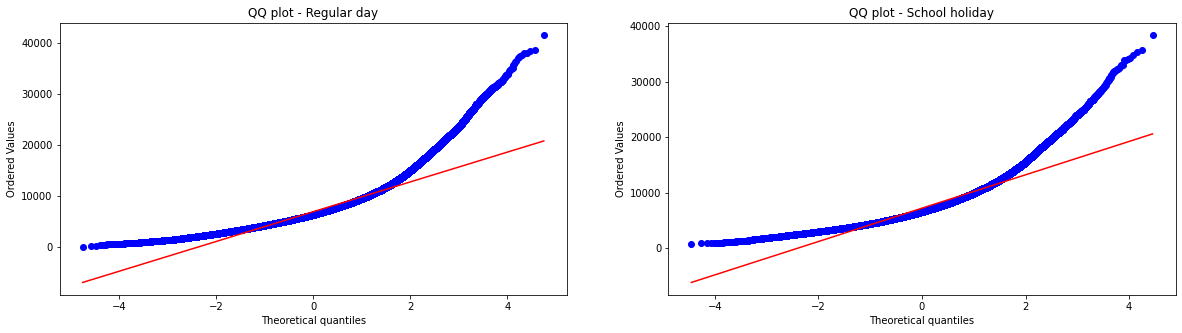

In [93]:
# ANOVA not suitable

plt.rcParams['figure.figsize'] = 20,5

plt.subplot( 1,2,1 )
stats.probplot( df5.loc[df5['school_holiday'] == 0, 'sales'], dist='norm', plot=plt );
plt.title( 'QQ plot - Regular day' );

plt.subplot( 1,2,2 )
stats.probplot( df5.loc[df5['school_holiday'] == 1, 'sales'], dist='norm', plot=plt );
plt.title( 'QQ plot - School holiday' );

plt.rcParams['figure.figsize'] = 20,10

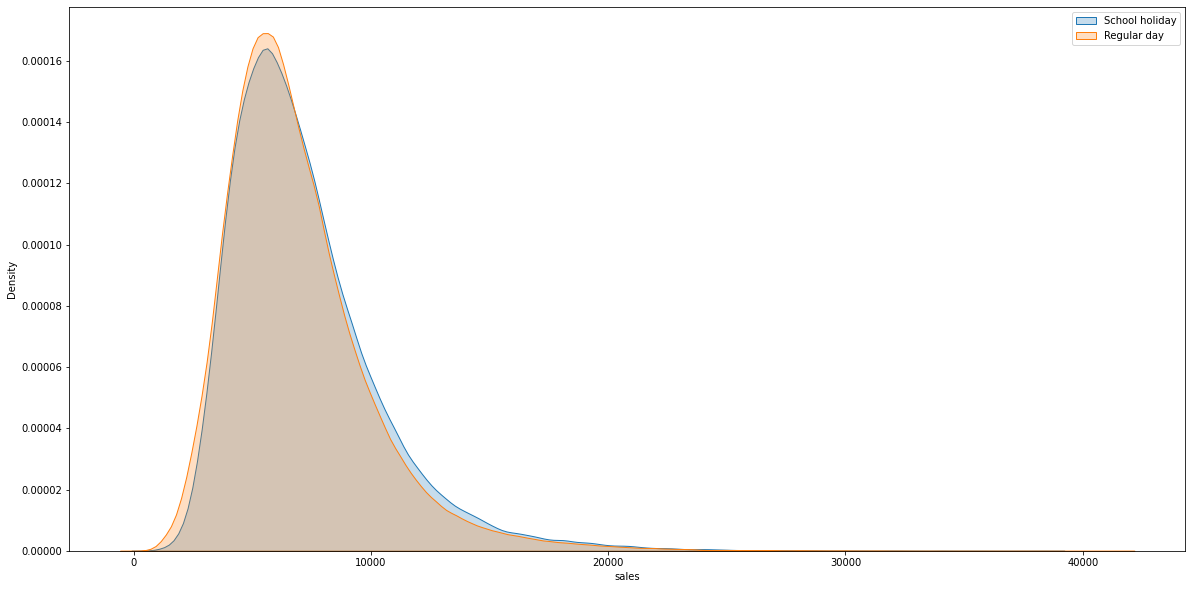

In [94]:
# Checking distributions shapes for Kruskal-Wallis test (below)

sns.kdeplot( df5[df5['school_holiday'] == 1]['sales'], label='School holiday', shade=True );
sns.kdeplot( df5[df5['school_holiday'] == 0]['sales'], label='Regular day', shade=True );
plt.legend();

# Very similar shapes → test says about the medians

In [95]:
# Kruskal-Wallis test

stats.kruskal( df5[df5['school_holiday'] == 1]['sales'], df5[df5['school_holiday'] == 0]['sales'] )

# The medians differ significantly

KruskalResult(statistic=1231.4297765510296, pvalue=9.01166150596318e-270)

### Stores open on weekends 🠒 lower income
_**<span style="color:red">True:</span>**_ indeed, the stores sell less on the weekends, in average. Futhermore, saturdays perform worse than sundays.

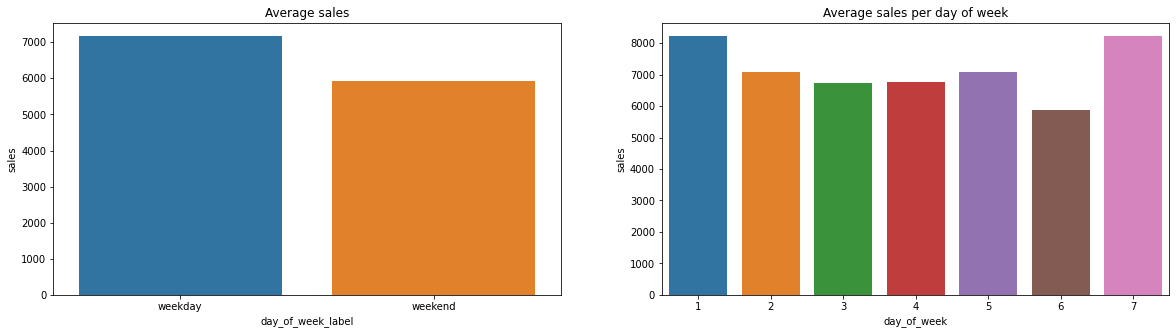

In [96]:
plt.rcParams['figure.figsize'] = 20,5

aux = df5[['sales','day_of_week']].copy()
aux['day_of_week_label'] = aux.apply( lambda x: 'weekend' if (x['day_of_week'] == 6) | (x['day_of_week'] == 7) else 'weekday', axis=1 )
aux2 = aux.groupby( 'day_of_week_label' ).mean().reset_index()
plt.subplot( 1,2,1 )
sns.barplot( x='day_of_week_label', y='sales', data=aux2 );
plt.title( 'Average sales' );

aux3 = df5.loc[:,['day_of_week','sales']].groupby( 'day_of_week' ).mean().reset_index()
plt.subplot( 1,2,2 )
sns.barplot( x='day_of_week', y='sales', data=aux3 );
plt.title( 'Average sales per day of week' );

#### Statistical analysis

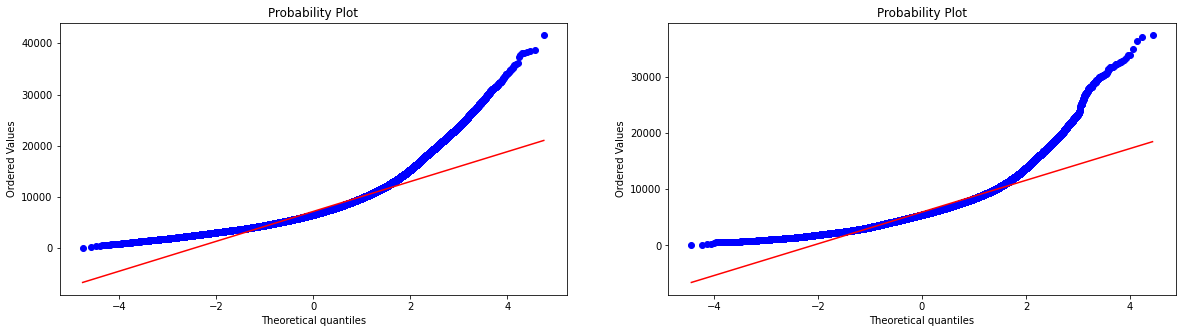

In [97]:
# ANOVA not suitable

plt.subplot( 1,2,1 );
stats.probplot( aux.loc[aux['day_of_week_label'] == 'weekday','sales'], dist='norm', plot=plt );

plt.subplot( 1,2,2 );
stats.probplot( aux.loc[aux['day_of_week_label'] == 'weekend','sales'], dist='norm', plot=plt );

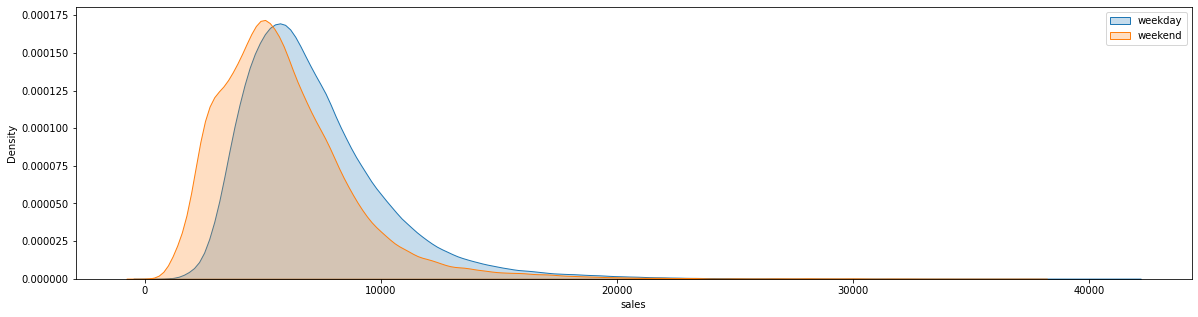

In [98]:
# Checking distributions shapes for Kruskal-Wallis test (below)

sns.kdeplot( aux.loc[aux['day_of_week_label'] == 'weekday','sales'], label='weekday', shade=True );
sns.kdeplot( aux.loc[aux['day_of_week_label'] == 'weekend','sales'], label='weekend', shade=True );
plt.legend();

# Different shapes → test will say about the mean ranks

plt.rcParams['figure.figsize'] = 20,10

In [99]:
# For hypothesis testing

stats.kruskal( aux.loc[aux['day_of_week_label'] == 'weekday','sales'], aux.loc[aux['day_of_week_label'] == 'weekend','sales'] )

# Mean ranks differ significantly

KruskalResult(statistic=26051.87827204049, pvalue=0.0)

In [100]:
# For model feature importance

stats.kruskal( aux3.loc[aux3['day_of_week'] == 1,'sales'], 
               aux3.loc[aux3['day_of_week'] == 2,'sales'],
               aux3.loc[aux3['day_of_week'] == 3,'sales'],
               aux3.loc[aux3['day_of_week'] == 4,'sales'],
               aux3.loc[aux3['day_of_week'] == 5,'sales'],
               aux3.loc[aux3['day_of_week'] == 6,'sales'],
               aux3.loc[aux3['day_of_week'] == 7,'sales'] )

# Not discernible from random pattern

KruskalResult(statistic=6.0, pvalue=0.42319008112684364)

### Stores open during Christmas 🠒 bigger income
_**<span style="color:red">True:</span>**_ in average, Christmas sales are higher than regular days and public holidays. However, Christmas performs very similar to Easter.

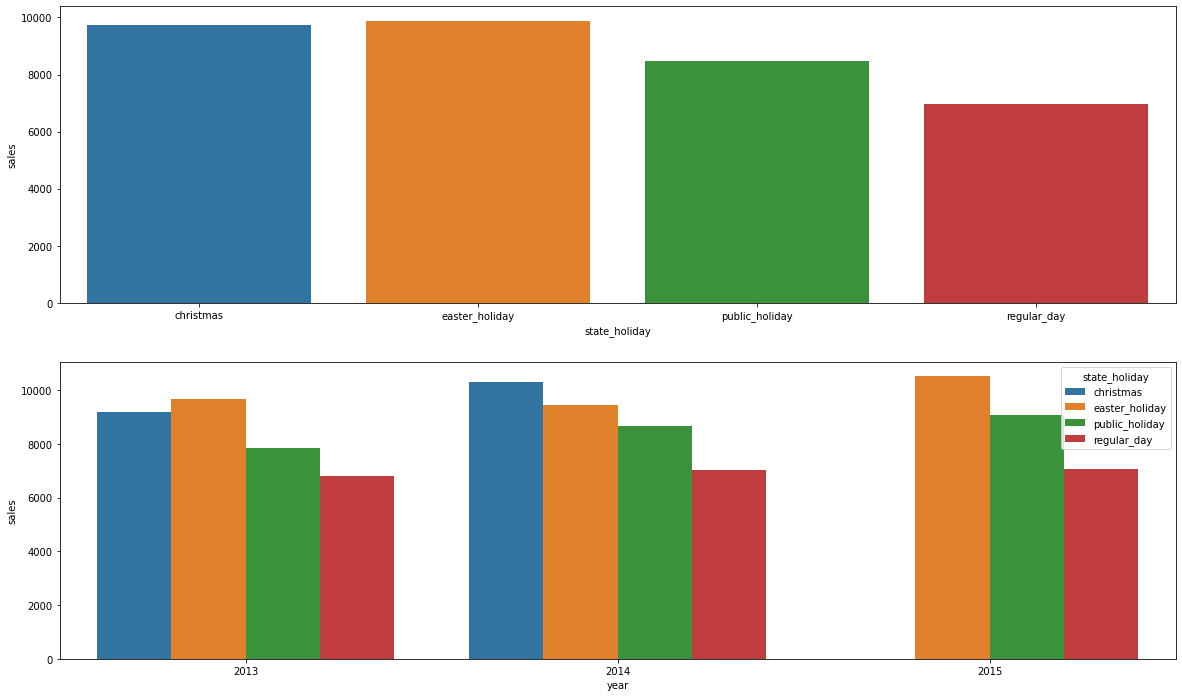

In [101]:
plt.rcParams['figure.figsize'] = 20,12

aux = df5.loc[:, ['state_holiday','sales']].groupby( 'state_holiday' ).mean().reset_index()
plt.subplot( 2,1,1 )
sns.barplot( x='state_holiday', y='sales', data=aux );

aux2 = df5.loc[:, ['year','state_holiday','sales']].groupby( ['year','state_holiday'] ).mean().reset_index()
plt.subplot( 2,1,2 )
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

plt.rcParams['figure.figsize'] = 20,10

#### Statistical analysis

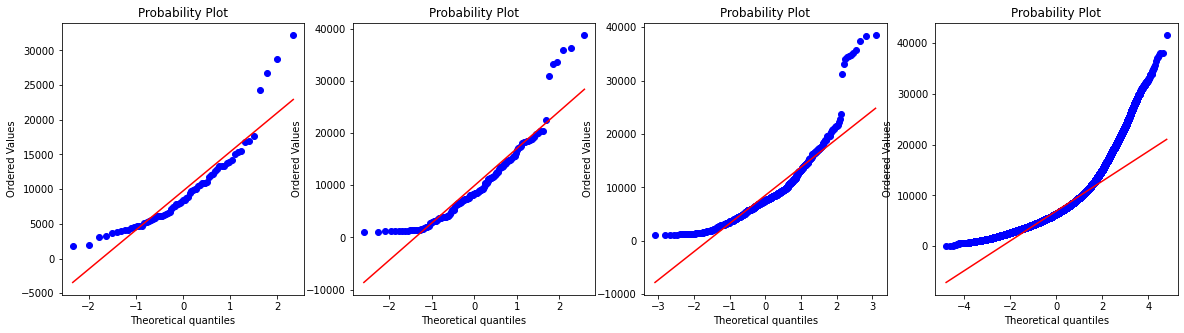

In [102]:
# ANOVA not suitable

plt.rcParams['figure.figsize'] = 20,5

plt.subplot( 1,4,1 )
stats.probplot( df5.loc[df5['state_holiday'] == 'christmas', 'sales'], dist='norm', plot=plt );

plt.subplot( 1,4,2 )
stats.probplot( df5.loc[df5['state_holiday'] == 'easter_holiday', 'sales'], dist='norm', plot=plt );

plt.subplot( 1,4,3 )
stats.probplot( df5.loc[df5['state_holiday'] == 'public_holiday', 'sales'], dist='norm', plot=plt );

plt.subplot( 1,4,4 )
stats.probplot( df5.loc[df5['state_holiday'] == 'regular_day', 'sales'], dist='norm', plot=plt );

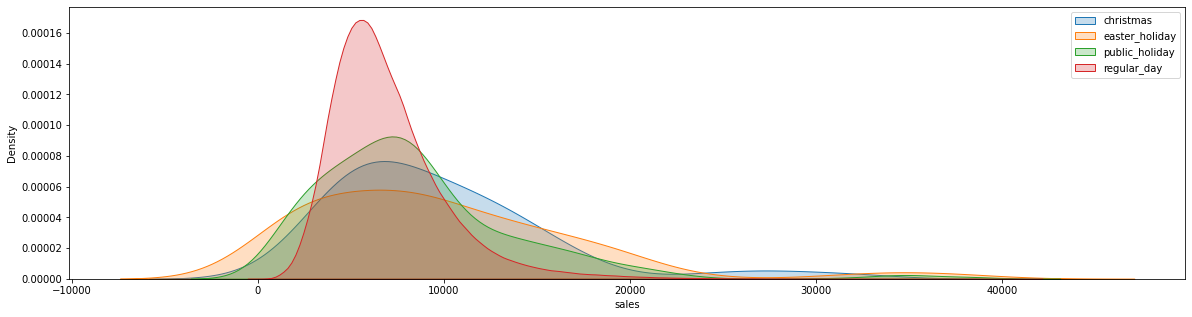

In [103]:
# Distributions shapes for Kruskal-Wallis test (below)

sns.kdeplot( df5.loc[df5['state_holiday'] == 'christmas', 'sales'], label='christmas', shade=True );
sns.kdeplot( df5.loc[df5['state_holiday'] == 'easter_holiday', 'sales'], label='easter_holiday', shade=True );
sns.kdeplot( df5.loc[df5['state_holiday'] == 'public_holiday', 'sales'], label='public_holiday', shade=True );
sns.kdeplot( df5.loc[df5['state_holiday'] == 'regular_day', 'sales'], label='regular_day', shade=True );
plt.legend();

# Different shapes → test outputs about mean ranks

plt.rcParams['figure.figsize'] = 20,10

In [104]:
stats.kruskal( df5.loc[df5['state_holiday'] == 'christmas', 'sales'],
               df5.loc[df5['state_holiday'] == 'easter_holiday', 'sales'],
               df5.loc[df5['state_holiday'] == 'public_holiday', 'sales'],
               df5.loc[df5['state_holiday'] == 'regular_day', 'sales'] )

# Mean ranks differ substantially 

KruskalResult(statistic=74.44515130724758, pvalue=4.764524580604207e-16)

In [105]:
# Post-hoc Dunn's test

sp.posthoc_dunn( df5, 'sales', 'state_holiday' )

# All of them differ significantly pairwise, except for Easter and Christmas

,christmas,easter_holiday,public_holiday,regular_day
christmas,1.000000,0.291739,3.361575e-02,2.362601e-05
easter_holiday,0.291739,1.000000,2.199005e-01,2.640740e-05
public_holiday,0.033616,0.219901,1.000000e+00,4.346760e-10
regular_day,0.000024,0.000026,4.346760e-10,1.000000e+00


### Along the passage of years 🠒 bigger income
_**<span style="color:red">True:</span>**_ in average, stores seem to perform better with the passage of years. For years with incomplete records, the same behavior is seen regarding total sales for the same periods.

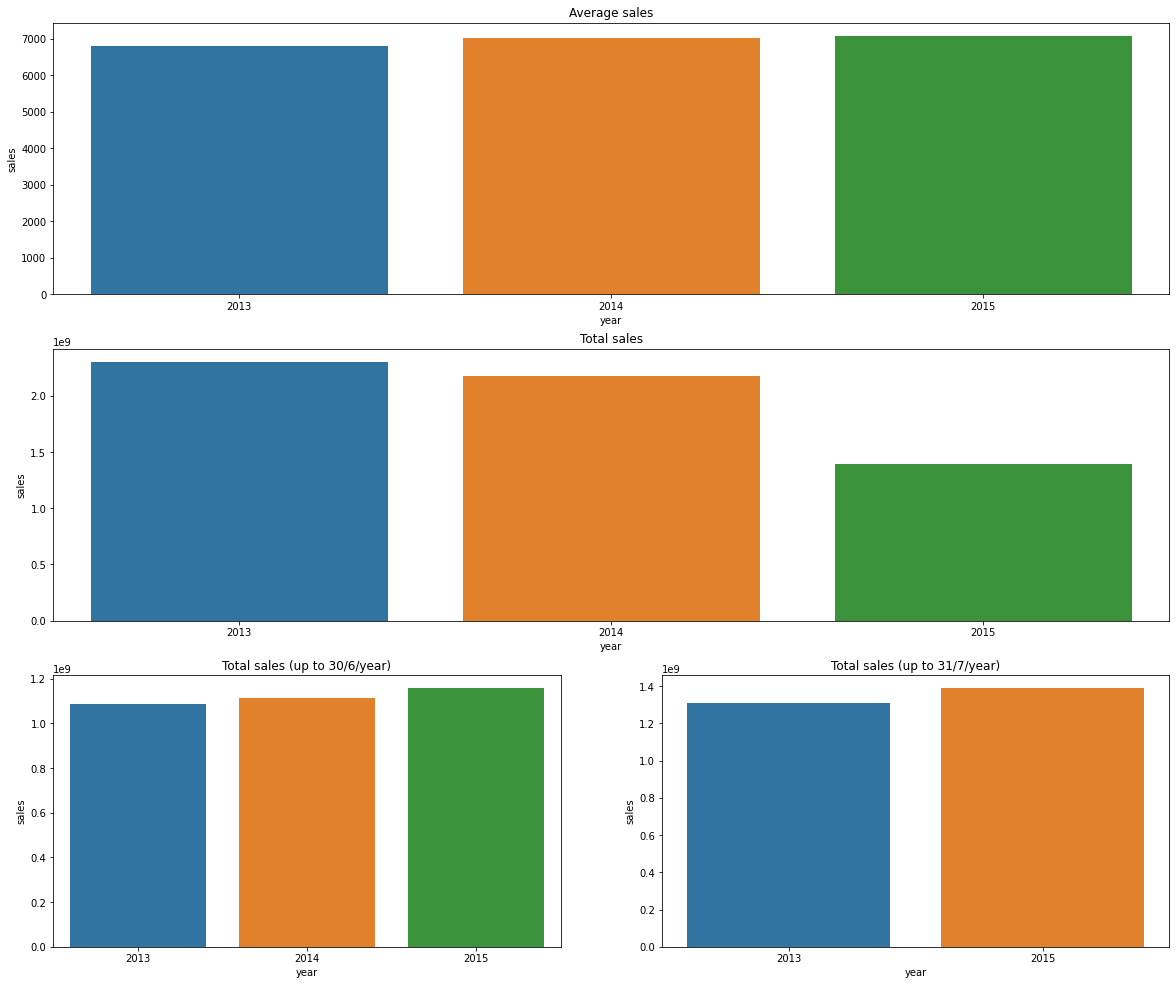

In [106]:
plt.rcParams['figure.figsize'] = 20,17
grid = gridspec.GridSpec(3,2)

aux = df5.loc[:,['year','sales']].groupby( 'year' ).mean().reset_index()
plt.subplot( grid[0,:] )
sns.barplot( x='year', y='sales', data=aux );
plt.title( 'Average sales' );

aux2 = df5.loc[:,['year','sales']].groupby( 'year' ).sum().reset_index()
plt.subplot( grid[1,:] )
sns.barplot( x='year', y='sales', data=aux2 );
plt.title( 'Total sales' );

day_lim_2014 = 30
month_lim_2014 = 6
aux3 = df5.loc[(df5['day'] <= day_lim_2014) & (df5['month'] <= month_lim_2014),['year','sales']].groupby( 'year' ).sum().reset_index()
plt.subplot( grid[2,0] )
sns.barplot( x='year', y='sales', data=aux3 );
plt.title( 'Total sales (up to 30/6/year)' );

day_lim_2015 = df5.loc[df5['year'] == 2015, 'date'].max().day
month_lim_2015 = df5.loc[df5['year'] == 2015, 'date'].max().month
aux4 = df5.loc[(df5['day'] <= day_lim_2015) & (df5['month'] <= month_lim_2015) & (df5['year'] != 2014),['year','sales']].groupby( 'year' ).sum().reset_index()
plt.subplot( grid[2,1] )
sns.barplot( x='year', y='sales', data=aux4 );
plt.title( 'Total sales (up to 31/7/year)' );

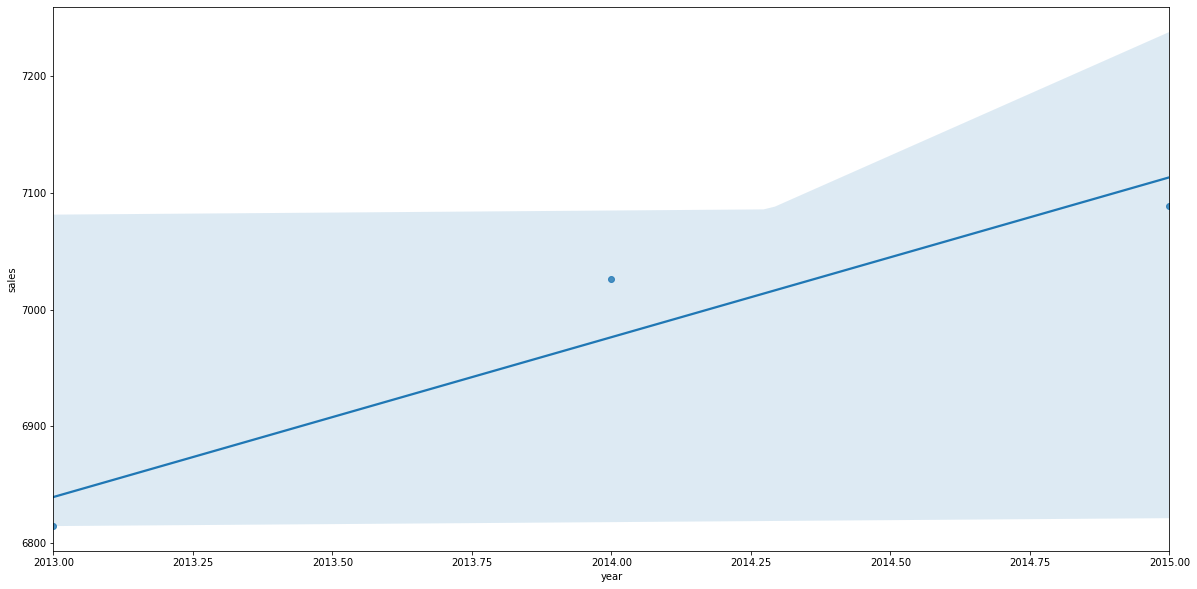

In [107]:
# Only to visualize a tendency, aware that a regression with just 3 points is a really longshot

plt.rcParams['figure.figsize'] = 20,10
sns.regplot( x='year', y='sales', data=aux );

In [108]:
stats.pearsonr( aux['year'], aux['sales'] )

# Not a statistical significant correlation

(0.9537709090113238, 0.19433017768389496)

#### <span style='color:purple'>Exploring 2014 date gap</span>

_Even though 2013 and 2014 have the same number of stores..._

In [109]:
df5[['store','year']].drop_duplicates().groupby( 'year' ).count().reset_index()

,year,store
0,2013,1115
1,2014,1115
2,2015,1115


_...and the same total time span,_

In [110]:
df5[['date','year']].drop_duplicates().groupby( 'year' ).apply( lambda x: x['date'].max() - x['date'].min() ).reset_index()

,year,0
0,2013,364 days
1,2014,364 days
2,2015,211 days


_We have "**Total Sales (2014) < Total Sales (2013)**", but "**Average Sales (2014) > Average Sales (2013)**"_.

_Checking what data is missing:_

In [111]:
# It is not due to filtering variables earlier

( df3[['sales','year']].groupby( 'year' ).count().reset_index() 
  - df5[['sales','year']].groupby( 'year' ).count().reset_index() )

,year,sales
0,0,69050
1,0,63470
2,0,40351


In [112]:
( df3.loc[(df3['sales'] <= 0) | (df3['open'] == 0),['sales','year']].groupby( 'year' )
                                                                    .count()
                                                                    .reset_index() )

,year,sales
0,2013,69050
1,2014,63470
2,2015,40351


In [113]:
# Some stores don't have records for all days of the year

df3.loc[df3['year'] == 2014,['sales','store']].groupby( 'store' ).count().reset_index().drop_duplicates( 'sales' )

,store,sales
0,1,365
12,13,181


In [114]:
# How much of each?

aux = df3.loc[df3['year'] == 2014,['sales','store']].groupby('store').count().reset_index()
aux[aux['sales'] == 365].shape[0]

935

In [115]:
# How much of each?

aux = df3.loc[df3['year'] == 2014,['sales','store']].groupby('store').count().reset_index()
aux[aux['sales'] == 181].shape[0]

180

In [116]:
# What is the data span for the defective ones?

grp = df3.loc[df3['year'] == 2014, ['date','store']].groupby( 'store' )

# Starts of periods
st = grp.apply( lambda x: x.loc[ x['date'] - pd.DateOffset( days = 1 ) 
                                 != x['date'].shift(-1), 'date' ] ).reset_index( level=1, drop=True )

# Ends of periods
en = grp.apply( lambda x: x.loc[ x['date'] + pd.DateOffset( days = 1 ) 
                                 != x['date'].shift(), 'date' ] ).reset_index( level=1, drop=True )

# Result - concat start / end dates
res = pd.concat([st, en], axis=1).reset_index()
# Set column names
res.columns = ['store', 'start', 'end']

res.drop_duplicates( ['start','end'] )

,store,start,end
0,1,2014-01-01,2014-12-31
12,13,2014-01-01,2014-06-30


**_Therefore, in 2014 there are 180 stores with records spanning the first semester only._**

### On the second semester of each year 🠒 bigger income
_**<span style="color:red">True:</span>**_ in average, stores have a better performance on the second semester of the year.

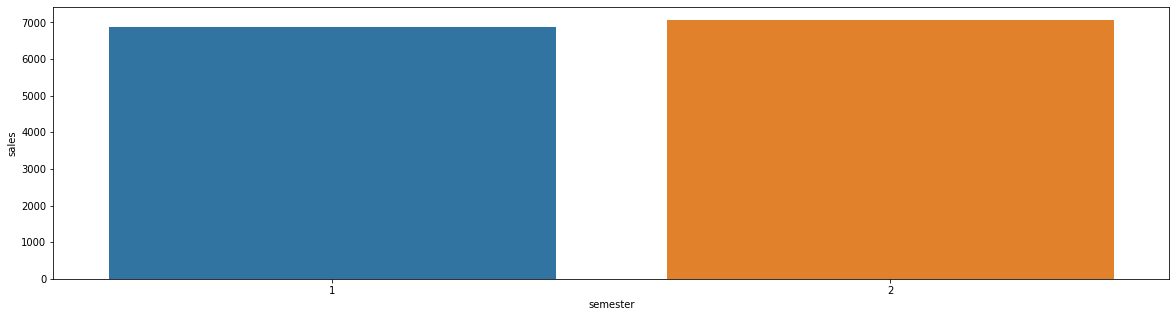

In [117]:
plt.rcParams['figure.figsize'] = 20,5

aux = df5.loc[:,['month','sales']].copy()
aux['semester'] = aux.apply( lambda x: 1 if x['month'] in [1,2,3,4,5,6] else 2, axis=1 )
aux2 = aux.drop( columns='month' ).groupby( 'semester' ).mean().reset_index()
sns.barplot( x='semester', y='sales', data=aux2 );

# Stores seem to perform better on the 2nd semester

#### Statistical analysis

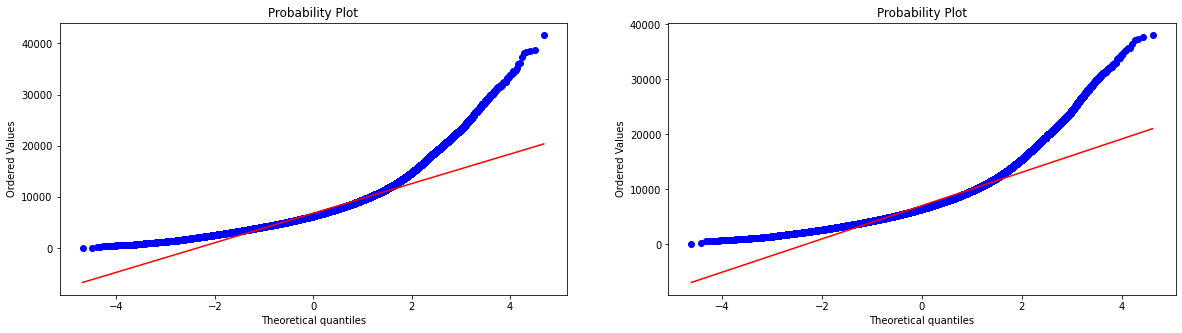

In [118]:
# ANOVA not suitable → Kruskal-Wallis

plt.subplot( 1,2,1 )
stats.probplot( aux.loc[aux['semester'] == 1, 'sales'], dist='norm', plot=plt );

plt.subplot( 1,2,2 )
stats.probplot( aux.loc[aux['semester'] == 2, 'sales'], dist='norm', plot=plt );

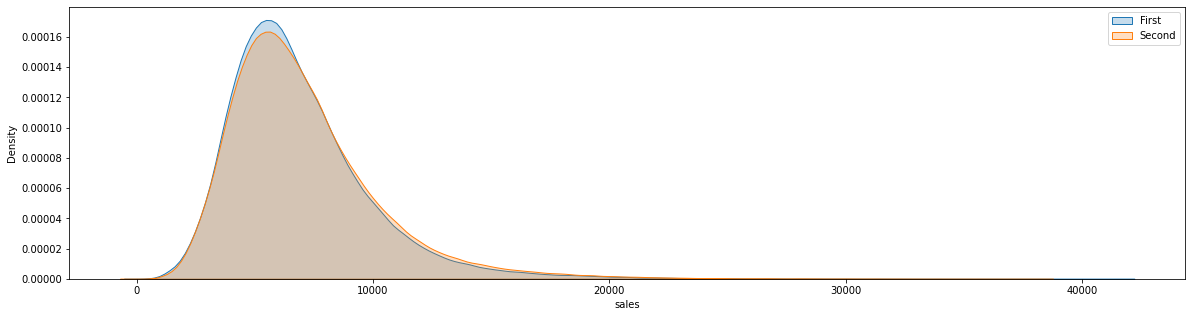

In [119]:
# Preparing for Kruskal-Wallis interpretation

sns.kdeplot( aux.loc[aux['semester'] == 1, 'sales'], label='First', shade=True );
sns.kdeplot( aux.loc[aux['semester'] == 2, 'sales'], label='Second', shade=True );
plt.legend();

# Similar shapes → comparison in terms of medians

In [120]:
stats.kruskal( aux.loc[aux['semester'] == 1, 'sales'], aux.loc[aux['semester'] == 2, 'sales'] )

# H0 rejected → medians differ significantly

KruskalResult(statistic=519.9716153073035, pvalue=4.292569712000364e-115)

### After the 10th day of each month 🠒 bigger income
_**<span style="color:red">False:</span>**_ the average performance is better for the days preceding the 10th day of each month.

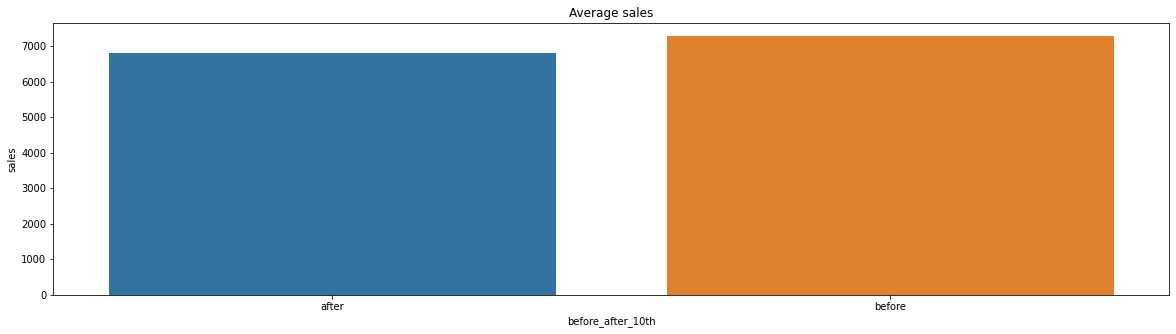

In [121]:
aux = df5[['day','sales']].copy()
aux['before_after_10th'] = aux['day'].apply( lambda x: 'before' if x <= 10 else 'after' )

aux2 = aux[['before_after_10th', 'sales']].groupby( 'before_after_10th' ).mean().reset_index()
sns.barplot( x='before_after_10th', y='sales', data=aux2 );
plt.title( 'Average sales' );

#### Statistical analysis

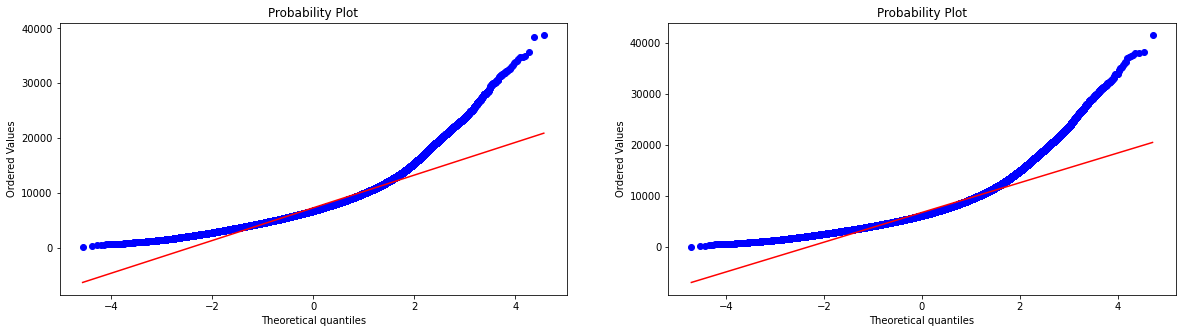

In [122]:
plt.subplot( 1,2,1 )
stats.probplot( aux.loc[aux['before_after_10th'] == 'before', 'sales'], dist='norm', plot=plt );

plt.subplot( 1,2,2 )
stats.probplot( aux.loc[aux['before_after_10th'] == 'after', 'sales'], dist='norm', plot=plt );

# ANOVA not suitable

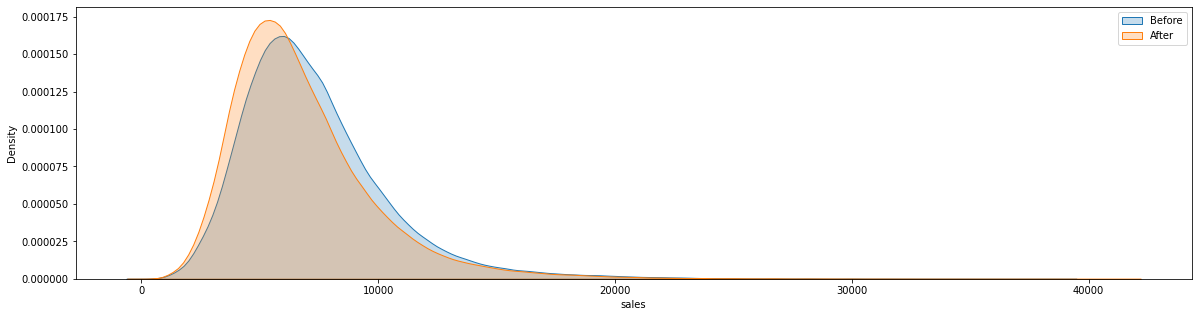

In [123]:
sns.kdeplot( aux.loc[aux['before_after_10th'] == 'before', 'sales'], label='Before', shade=True );
sns.kdeplot( aux.loc[aux['before_after_10th'] == 'after', 'sales'], label='After', shade=True );
plt.legend();

# Similar shapes → Kruskal-Wallis test will be interpreted in terms of shifts in location

In [124]:
stats.kruskal( aux.loc[aux['before_after_10th'] == 'before', 'sales'], aux.loc[aux['before_after_10th'] == 'after', 'sales'] )

# The difference is statistically significant

KruskalResult(statistic=6818.173472386991, pvalue=0.0)

## Multivariate analysis

### Numerical attributes

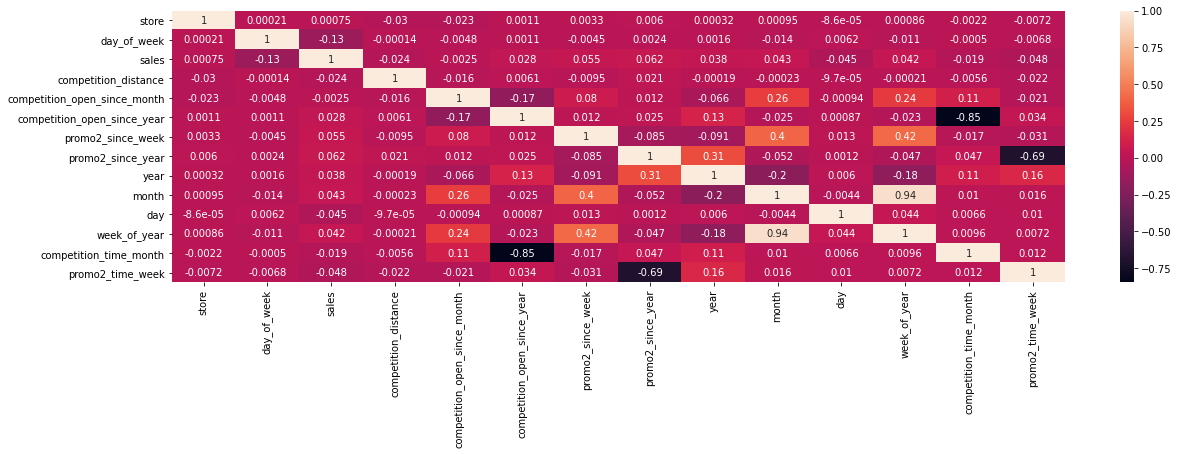

In [125]:
sns.heatmap( num_attributes.corr( method = 'kendall' ), annot=True );

### Categorical attributes

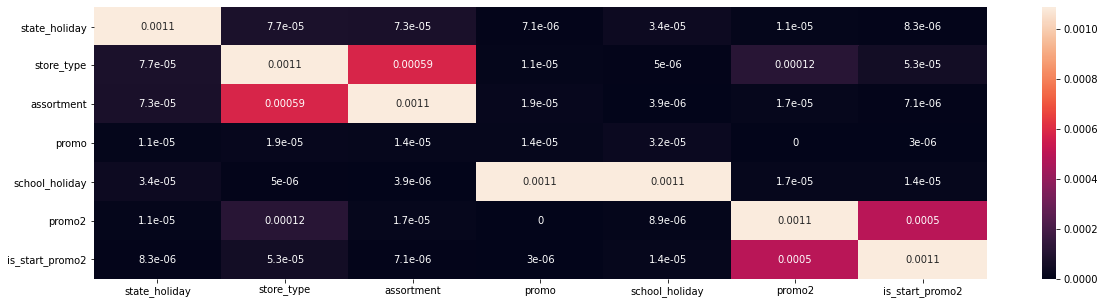

In [126]:
# Shorthand
aux = cat_attributes

a1 = cramerv( aux['state_holiday'], aux['state_holiday'] )
a2 = cramerv( aux['state_holiday'], aux['store_type'] )
a3 = cramerv( aux['state_holiday'], aux['assortment'] )
a4 = cramerv( aux['state_holiday'], aux['promo'] )
a5 = cramerv( aux['state_holiday'], aux['school_holiday'] )
a6 = cramerv( aux['state_holiday'], aux['promo2'] )
a7 = cramerv( aux['state_holiday'], aux['is_start_promo2'] )

a8 = cramerv( aux['store_type'], aux['state_holiday'] )
a9 = cramerv( aux['store_type'], aux['store_type'] )
a10 = cramerv( aux['store_type'], aux['assortment'] )
a11 = cramerv( aux['store_type'], aux['promo'] )
a12 = cramerv( aux['store_type'], aux['school_holiday'] )
a13 = cramerv( aux['store_type'], aux['promo2'] )
a14 = cramerv( aux['store_type'], aux['is_start_promo2'] )

a15 = cramerv( aux['assortment'], aux['state_holiday'] )
a16 = cramerv( aux['assortment'], aux['store_type'] )
a17 = cramerv( aux['assortment'], aux['assortment'] )
a18 = cramerv( aux['assortment'], aux['promo'] )
a19 = cramerv( aux['assortment'], aux['school_holiday'] )
a20 = cramerv( aux['assortment'], aux['promo2'] )
a21 = cramerv( aux['assortment'], aux['is_start_promo2'] )

a22 = cramerv( aux['promo'], aux['state_holiday'] )
a23 = cramerv( aux['promo'], aux['store_type'] )
a24 = cramerv( aux['promo'], aux['assortment'] )
a25 = cramerv( aux['promo'], aux['promo'] )
a26 = cramerv( aux['promo'], aux['school_holiday'] )
a27 = cramerv( aux['promo'], aux['promo2'] )
a28 = cramerv( aux['promo'], aux['is_start_promo2'] )

a29 = cramerv( aux['school_holiday'], aux['state_holiday'] )
a30 = cramerv( aux['school_holiday'], aux['store_type'] )
a31 = cramerv( aux['school_holiday'], aux['assortment'] )
a32 = cramerv( aux['school_holiday'], aux['promo'] )
a33 = cramerv( aux['school_holiday'], aux['school_holiday'] )
a34 = cramerv( aux['school_holiday'], aux['promo2'] )
a35 = cramerv( aux['school_holiday'], aux['is_start_promo2'] )

a36 = cramerv( aux['promo2'], aux['state_holiday'] )
a37 = cramerv( aux['promo2'], aux['store_type'] )
a38 = cramerv( aux['promo2'], aux['assortment'] )
a39 = cramerv( aux['promo2'], aux['promo'] )
a40 = cramerv( aux['promo2'], aux['school_holiday'] )
a41 = cramerv( aux['promo2'], aux['promo2'] )
a42 = cramerv( aux['promo2'], aux['is_start_promo2'] )

a43 = cramerv( aux['is_start_promo2'], aux['state_holiday'] )
a44 = cramerv( aux['is_start_promo2'], aux['store_type'] )
a45 = cramerv( aux['is_start_promo2'], aux['assortment'] )
a46 = cramerv( aux['is_start_promo2'], aux['promo'] )
a47 = cramerv( aux['is_start_promo2'], aux['school_holiday'] )
a48 = cramerv( aux['is_start_promo2'], aux['promo2'] )
a49 = cramerv( aux['is_start_promo2'], aux['is_start_promo2'] )

cat_corr = pd.DataFrame( { 'state_holiday': [a1, a2, a3, a4, a5, a6, a7],
                           'store_type': [a8, a9, a10, a11, a12, a13, a14],
                           'assortment': [a15, a16, a17, a18, a19, a20, a21],
                           'promo': [a21, a22, a23, a24, a25, a27, a28],
                           'school_holiday': [a29, a30, a31, a32, a33, a34, a35],
                           'promo2': [a36, a37, a38, a39, a20, a41, a42],
                           'is_start_promo2': [a43, a44, a45, a46, a47, a48, a49] } )

cat_corr = cat_corr.set_index( cat_corr.columns )

sns.heatmap( cat_corr, annot=True );

# DATA PREPARATION

In [53]:
df6 = df5.copy()

## <s>Standardization</s>
Checking the univariate EDA, one sees that no distribution is close to normal, to which standardization (`preprocessing.StandardScaler`) would be best suited

## Rescaling

In [54]:
rs = RobustScaler()
mms = MinMaxScaler()

df6.loc[:,'competition_distance'] = rs.fit_transform( df6.loc[:,['competition_distance']] )
pickle.dump( rs, open( '../parameters/competition_distance_scaler.pkl', 'wb' ) )

df6.loc[:,'competition_time_month'] = rs.fit_transform( df6.loc[:,['competition_time_month']] )
pickle.dump( rs, open( '../parameters/competition_time_month_scaler.pkl', 'wb' ) )

df6.loc[:,'promo2_time_week'] = mms.fit_transform( df6.loc[:,['promo2_time_week']] )
pickle.dump( mms, open( '../parameters/promo2_time_week_scaler.pkl', 'wb' ) )

df6.loc[:,'year'] = mms.fit_transform( df6.loc[:,['year']] )
pickle.dump( mms, open( '../parameters/year_scaler.pkl', 'wb' ) )

df6.loc[:,'store'] = mms.fit_transform( df6.loc[:,['store']] )
pickle.dump( mms, open( '../parameters/store_scaler.pkl', 'wb' ) )

df6.loc[:,'competition_open_since_year'] = rs.fit_transform( df6.loc[:,['competition_open_since_year']] )
pickle.dump( rs, open( '../parameters/competition_open_since_year_scaler.pkl', 'wb' ) )

df6.loc[:,'promo2_since_year'] = mms.fit_transform( df6.loc[:,['promo2_since_year']] )
pickle.dump( mms, open( '../parameters/promo2_since_year_scaler.pkl', 'wb' ) )

## Transformation

### Categorical variables encoding

In [55]:
# state_holiday - One Hot Encoding
df6 = pd.get_dummies( df6, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df6.loc[:,'store_type'] = le.fit_transform( df6.loc[:,'store_type'] )
pickle.dump( le, open( '../parameters/store_type_encoder.pkl', 'wb' ) )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 0, 'extra': 1, 'extended': 2}
df6.loc[:,'assortment'] = df6.loc[:,'assortment'].map( assortment_dict )

### Nature transformation

In [56]:
# Normalizing sales - Target variable
df6.loc[:,'sales'] = np.log1p( df6.loc[:,'sales'] )

In [57]:
# Cyclic (temporal) features

# day_of_week
df6.loc[:,'day_of_week_sin'] = df6.loc[:,'day_of_week'].apply( lambda x: np.sin( x*2*np.pi/7 ) )
df6.loc[:,'day_of_week_cos'] = df6.loc[:,'day_of_week'].apply( lambda x: np.cos( x*2*np.pi/7 ) )

# month
df6.loc[:,'month_sin'] = df6.loc[:,'month'].apply( lambda x: np.sin( x*2*np.pi/12 ) )
df6.loc[:,'month_cos'] = df6.loc[:,'month'].apply( lambda x: np.cos( x*2*np.pi/12 ) )

# day
df6.loc[:,'day_sin'] = df6.loc[:,'day'].apply( lambda x: np.sin( x*2*np.pi/30 ) )
df6.loc[:,'day_cos'] = df6.loc[:,'day'].apply( lambda x: np.cos( x*2*np.pi/30 ) )

# week_of_year
df6.loc[:,'week_of_year_sin'] = df6.loc[:,'week_of_year'].apply( lambda x: np.sin( x*2*np.pi/52 ) )
df6.loc[:,'week_of_year_cos'] = df6.loc[:,'week_of_year'].apply( lambda x: np.cos( x*2*np.pi/52 ) )

# competition_open_since_month
df6.loc[:,'competition_open_since_month_sin'] = df6.loc[:,'competition_open_since_month'].apply( lambda x: np.sin( x*2*np.pi/12 ) )
df6.loc[:,'competition_open_since_month_cos'] = df6.loc[:,'competition_open_since_month'].apply( lambda x: np.cos( x*2*np.pi/12 ) )

# promo2_since_week
df6.loc[:,'promo2_since_week_sin'] = df6.loc[:,'promo2_since_week'].apply( lambda x: np.sin( x*2*np.pi/52 ) )
df6.loc[:,'promo2_since_week_cos'] = df6.loc[:,'promo2_since_week'].apply( lambda x: np.cos( x*2*np.pi/52 ) )

In [132]:
df6.sample(5)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_start_promo2,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,competition_open_since_month_sin,competition_open_since_month_cos,promo2_since_week_sin,promo2_since_week_cos
920799,0.533214,4,2013-03-28,10.112776,1,1,2,2,-0.193548,6,0.500000,0,13,0.666667,0,0.0,3,28,12,2013-12,2015-06-01,-0.581081,2013-04-01,0.287016,0,0,0,1,-4.338837e-01,-0.900969,1.000000,6.123234e-17,-0.406737,0.913545,0.992709,0.120537,1.224647e-16,-1.000000e+00,1.000000,-1.608123e-16
516290,0.745063,3,2014-03-26,9.125218,0,0,0,0,-0.246774,6,-0.833333,0,13,0.833333,0,0.5,3,26,12,2014-12,2007-06-01,0.905405,2014-03-31,0.287016,0,0,0,1,4.338837e-01,-0.900969,1.000000,6.123234e-17,-0.743145,0.669131,0.992709,0.120537,1.224647e-16,-1.000000e+00,1.000000,-1.608123e-16
497466,0.862657,6,2014-04-12,8.465479,0,0,2,0,-0.333871,4,0.333333,0,15,0.833333,0,0.5,4,12,14,2014-14,2014-04-01,-0.216216,2014-04-14,0.287016,0,0,0,1,-7.818315e-01,0.623490,0.866025,-5.000000e-01,0.587785,-0.809017,0.992709,-0.120537,8.660254e-01,-5.000000e-01,0.970942,-2.393157e-01
349782,0.290844,1,2014-09-01,9.226804,1,0,0,2,-0.319355,3,-0.166667,1,22,0.333333,0,0.5,9,1,35,2014-35,2011-03-01,0.351351,2011-05-30,0.676538,0,0,0,1,7.818315e-01,0.623490,-1.000000,-1.836970e-16,0.207912,0.978148,-0.885456,-0.464723,1.000000e+00,6.123234e-17,0.464723,-8.854560e-01
495919,0.474865,7,2014-04-13,8.447629,0,0,0,2,2.553226,4,0.333333,0,15,0.833333,0,0.5,4,13,14,2014-14,2014-04-01,-0.216216,2014-04-14,0.287016,0,0,0,1,-2.449294e-16,1.000000,0.866025,-5.000000e-01,0.406737,-0.913545,0.992709,-0.120537,8.660254e-01,-5.000000e-01,0.970942,-2.393157e-01


# FEATURE SELECTION

In [58]:
df7 = df6.copy()

## Data split (training and test)

In [59]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'competition_open_since_month', 'promo2_since_week', # Transformed to sin, cos
             'promo2_since', 'competition_since', # Used temporarily for feature engineering 
             'year_week'] # Used only for EDA (it's an 'object')
df7 = df7.drop( cols_drop, axis=1 )

In [60]:
date_threshold = df7.loc[:,['store','date']].groupby('store').max().reset_index().loc[0,'date'] - datetime.timedelta( weeks=6 )

In [61]:
X_train = df7.loc[df7.loc[:,'date'] < date_threshold,:]
y_train = X_train.loc[:,'sales']

X_test = df7.loc[df7.loc[:,'date'] >= date_threshold,:]
y_test = X_test.loc[:,'sales']

print( 'Min. date for training set: {}'.format( X_train.loc[:,'date'].min() ) )
print( 'Max. date for training set: {}'.format( X_train.loc[:,'date'].max() ) )

print( 'Min. date for test set: {}'.format( X_test.loc[:,'date'].min() ) )
print( 'Max. date for test set: {}'.format( X_test.loc[:,'date'].max() ) )

Min. date for training set: 2013-01-01 00:00:00
Max. date for training set: 2015-06-18 00:00:00
Min. date for test set: 2015-06-19 00:00:00
Max. date for test set: 2015-07-31 00:00:00


## Boruta as a feature selector

In [62]:
# Preparing arrays from dataframes 
X_train_n = X_train.drop( columns=['date','sales'] ).values
y_train_n = y_train.values

# Preparing Random Forest
rf = RandomForestRegressor( n_jobs=-1 )

# Defining boruta (should be run only once, results are displayed in the section below)
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )
cols_selected = X_train.drop(columns=['date','sales']).columns[boruta.support_].to_list()
cols_not_selected = list( np.setdiff1d( X_train.drop(columns=['date','sales']).columns, cols_selected ) )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	19
Tentative: 	0
Rejected: 	10


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	19
Tentative: 	0
Rejected: 	10


### Results of the selection

In [138]:
# Below are the boruta output's copied for future runs

cols_selected = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_year',
    'promo2',
    'promo2_since_year',
    'competition_time_month',
    'promo2_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_cos',
    'day_sin',
    'day_cos',
    'competition_open_since_month_sin',
    'competition_open_since_month_cos',
    'promo2_since_week_sin',
    'promo2_since_week_cos']

cols_not_selected = [
    'is_start_promo2',
     'month_sin',
     'school_holiday',
     'state_holiday_christmas',
     'state_holiday_easter_holiday',
     'state_holiday_public_holiday',
     'state_holiday_regular_day',
     'week_of_year_cos',
     'week_of_year_sin',
     'year']

In [62]:
# Completing the output with missing sines/cosines

cols_selected = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_year',
    'promo2',
    'promo2_since_year',
    'competition_time_month',
    'promo2_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'competition_open_since_month_sin',
    'competition_open_since_month_cos',
    'promo2_since_week_sin',
    'promo2_since_week_cos']


cols_not_selected = [
    'is_start_promo2',
     'school_holiday',
     'state_holiday_christmas',
     'state_holiday_easter_holiday',
     'state_holiday_public_holiday',
     'state_holiday_regular_day',
     'week_of_year_cos',
     'week_of_year_sin',
     'year']

feats_to_add = ['date', 'sales']

cols_selected_full = cols_selected.copy()
cols_selected_full.extend( feats_to_add )

# MACHINE LEARNING MODELING

In [63]:
x_train = X_train[cols_selected].copy()
x_test = X_test[cols_selected].copy()

x_train_kfold = X_train[cols_selected_full].copy()

## Average Model (baseline)

In [161]:
aux1 = x_train.copy()
aux1.loc[:,'sales'] = y_train.copy()
aux2 = x_test.copy()

# Prediction
aux3 = aux1.loc[:,['store','sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales':'predictions'} )
aux2 = pd.merge( aux2, aux3, how='left', on='store' )
yhat_baseline = aux2.loc[:,'predictions']

# Performance
baseline_result = ml_error( 'Average', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model name,MAE,MAPE,RMSE
0,Average,1429.763326,0.44785,1939.32873


## Linear Regression Model

In [162]:
# Model
lr = LinearRegression().fit( x_train, y_train )

# Prediction
yhat_lr = lr.predict( x_test )

# Performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model name,MAE,MAPE,RMSE
0,Linear Regression,1864.963643,0.289887,2684.100135


### Cross-validation

In [170]:
lr_result_cv = cross_validation( x_train_kfold, 5, 'Linear Regression', lr, verbose=True )


KFold number: 0

KFold number: 1

KFold number: 2

KFold number: 3

KFold number: 4


In [171]:
lr_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2098.69 +/- 323.81,0.3 +/- 0.02,2989.41 +/- 505.97


## Regularized Linear Regression Model - Lasso

In [163]:
# Model
lasso = Lasso( alpha=0.01 ).fit( x_train, y_train )

# Prediction
yhat_lasso = lasso.predict( x_test )

# Performance
lasso_result = ml_error( 'Regularized Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lasso ) )
lasso_result

,Model name,MAE,MAPE,RMSE
0,Regularized Linear Regression - Lasso,1898.703999,0.288481,2766.585318


### Cross-validation

In [172]:
lasso_result_cv = cross_validation( x_train_kfold, 5, 'Lasso', lasso, verbose=True )


KFold number: 0

KFold number: 1

KFold number: 2

KFold number: 3

KFold number: 4


In [173]:
lasso_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2129.78 +/- 369.49,0.3 +/- 0.01,3069.62 +/- 550.58


## Random Forest Regressor

In [156]:
# Model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# Prediction
yhat_rf = rf.predict( x_test )

# Performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model name,MAE,MAPE,RMSE
0,Random Forest Regressor,688.575018,0.102779,1013.321423


### Cross-validation

In [174]:
rf_result_cv = cross_validation( x_train_kfold, 5, 'Random Forest Regressor', rf, verbose=True )


KFold number: 0

KFold number: 1

KFold number: 2

KFold number: 3

KFold number: 4


In [175]:
rf_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,861.3 +/- 246.09,0.12 +/- 0.03,1274.63 +/- 354.57


## XGBoost Regressor

In [64]:
# Model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# Prediction
yhat_xgb = model_xgb.predict( x_test )

# Performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model name,MAE,MAPE,RMSE
0,XGBoost Regressor,827.133912,0.121559,1203.641973


### Cross-validation

In [65]:
xgb_result_cv = cross_validation( x_train_kfold, 5, 'XGBoost Regressor', model_xgb, verbose=True )


KFold number: 0

KFold number: 1

KFold number: 2

KFold number: 3

KFold number: 4


In [66]:
xgb_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1035.44 +/- 194.91,0.14 +/- 0.02,1488.23 +/- 266.8


## Comparing models performances

### Single performance

In [67]:
modeling_results = pd.concat( [baseline_result, lr_result, lasso_result, rf_result, xgb_result] ).sort_values( 'RMSE' ).reset_index( drop=True )
modeling_results

,Model name,MAE,MAPE,RMSE
0,Random Forest Regressor,688.575018,0.102779,1013.321423
1,XGBoost Regressor,827.133912,0.121559,1203.641973
2,Average,1429.763326,0.447850,1939.328730
3,Linear Regression,1864.963643,0.289887,2684.100135
4,Regularized Linear Regression - Lasso,1898.703999,0.288481,2766.585318


### Real performance - Cross-validation

In [68]:
modeling_results_cv = pd.concat( [lr_result_cv, lasso_result_cv, rf_result_cv, xgb_result_cv] ).sort_values( 'RMSE CV' ).reset_index( drop=True )
modeling_results_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,861.3 +/- 246.09,0.12 +/- 0.03,1274.63 +/- 354.57
1,XGBoost Regressor,1035.44 +/- 194.91,0.14 +/- 0.02,1488.23 +/- 266.8
2,Linear Regression,2098.69 +/- 323.81,0.3 +/- 0.02,2989.41 +/- 505.97
3,Regularized Linear Regression - Lasso,2129.78 +/- 369.49,0.3 +/- 0.01,3069.62 +/- 550.58


# HYPERPARAMETER FINE TUNING

<span style='color:purple'>**_Even though the XGBRegressor was the second best model in the above, the fine tuning will also be carried out for it, in addition to for the RandomForestRegressor._**</span>

<span style='color:purple'>**_Based on previous experience, the hierarchy between them may change after the fine tuning._**</span>

## XGBoost Regressor - Random Search

In [69]:
params = {'n_estimators':[1500, 1700, 2500, 3000, 3500],
          'eta':[0.01, 0.03],
          'max_depth':[3, 5, 9],
          'subsample':[0.1, 0.5, 0.7],
          'colsample_bytree':[0.3, 0.7, 0.9],
          'min_child_weight':[3, 8, 15]}

max_eval = 9

In [70]:
final_result = pd.DataFrame()

for i in range( max_eval ):
    print( '\nCycle #: {}'.format(i) )
    
    # Cycle randomly through the former parameter list
    hp = {k: random.sample( v, 1 )[0] for k, v in params.items()}
    print(hp)
    
    # Model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )
    
    # Performance
    result = cross_validation( x_train_kfold, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] ).reset_index( drop=True )


Cycle #: 0
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}

KFold number: 0

KFold number: 1

KFold number: 2

KFold number: 3

KFold number: 4

Cycle #: 1
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}

KFold number: 0

KFold number: 1

KFold number: 2

KFold number: 3

KFold number: 4

Cycle #: 2
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}

KFold number: 0

KFold number: 1

KFold number: 2

KFold number: 3

KFold number: 4

Cycle #: 3
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}

KFold number: 0

KFold number: 1

KFold number: 2

KFold number: 3

KFold number: 4

Cycle #: 4
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}

KFold n

In [71]:
final_result

,Model name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1120.94 +/- 120.39,0.16 +/- 0.01,1599.26 +/- 152.36
1,XGBoost Regressor,933.24 +/- 110.72,0.13 +/- 0.01,1324.17 +/- 164.88
2,XGBoost Regressor,850.87 +/- 115.23,0.12 +/- 0.01,1213.24 +/- 164.72
3,XGBoost Regressor,1132.21 +/- 131.04,0.16 +/- 0.02,1603.36 +/- 170.74
4,XGBoost Regressor,1069.5 +/- 115.06,0.15 +/- 0.01,1524.27 +/- 148.17
5,XGBoost Regressor,1053.06 +/- 133.14,0.15 +/- 0.01,1497.36 +/- 176.98
6,XGBoost Regressor,817.73 +/- 115.51,0.12 +/- 0.01,1183.78 +/- 168.7
7,XGBoost Regressor,1268.62 +/- 128.87,0.18 +/- 0.01,1807.75 +/- 159.57
8,XGBoost Regressor,830.89 +/- 116.83,0.12 +/- 0.01,1203.12 +/- 184.77


### Final Model

In [73]:
# Tuned Model
tuned_model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
                                     n_estimators=tuned_params['n_estimators'],
                                     eta=tuned_params['eta'],
                                     max_depth=tuned_params['max_depth'],
                                     subsample=tuned_params['subsample'],
                                     colsample_bytree=tuned_params['colsample_bytree'],
                                     min_child_weight=tuned_params['min_child_weight'] ).fit( x_train, y_train )

# Prediction
tuned_yhat_xgb = tuned_model_xgb.predict( x_test )

# Performance
tuned_xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( tuned_yhat_xgb ) )
tuned_xgb_result

,Model name,MAE,MAPE,RMSE
0,XGBoost Regressor,650.947277,0.095251,944.954534


In [74]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( tuned_yhat_xgb ) )
mpe

-0.003306395380147658

In [75]:
# Saving
pickle.dump( tuned_model_xgb, open( '../model/tuned_xgb_rossmann_xgbdowngrade.pkl', 'wb' ) )

**_Final file has 79MB. We shall compare it later with the Random Forest._**

## Random Forest Regressor - Random Search

In [172]:
# Ballpark figure for the depth of the tree (from the Forest trained ealier)
np.mean( [estimator.tree_.max_depth for estimator in rf.estimators_] )

51.73

In [64]:
params = { 'n_estimators': [60, 100, 200, 300],
           'max_depth': [30, 40, 50, None],
           'max_features': ['sqrt', 'auto', 'log2'],
           'min_samples_split': [2, 5, 8, 10],
           'min_samples_leaf': [1, 2, 3, 4] }

max_eval = 9

In [65]:
final_result = pd.DataFrame()

for i in range( max_eval ):
    print( '\nCycle #: {}\n'.format(i) )
    
    # Cycle randomly through the former parameter list
    hp = {k: random.sample( v, 1 )[0] for k, v in params.items()}
    print(hp)
    
    # Model
    model_rf = RandomForestRegressor( n_jobs=-1, 
                                      random_state=42,
                                      n_estimators=hp['n_estimators'],
                                      max_depth=hp['max_depth'],
                                      max_features=hp['max_features'],
                                      min_samples_split=hp['min_samples_split'],
                                      min_samples_leaf=hp['min_samples_leaf'] )
    
    # Performance
    result = cross_validation( x_train_kfold, 5, 'Random Forest Regressor', model_rf, verbose=True )
    final_result = pd.concat( [final_result, result] ).reset_index( drop=True )


Cycle #: 0

{'n_estimators': 300, 'max_depth': 30, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 4}

KFold number: 0

KFold number: 1

KFold number: 2

KFold number: 3

KFold number: 4

Cycle #: 1

{'n_estimators': 100, 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 2}

KFold number: 0

KFold number: 1

KFold number: 2

KFold number: 3

KFold number: 4

Cycle #: 2

{'n_estimators': 300, 'max_depth': 40, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 3}

KFold number: 0

KFold number: 1

KFold number: 2

KFold number: 3

KFold number: 4

Cycle #: 3

{'n_estimators': 300, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 3}

KFold number: 0

KFold number: 1

KFold number: 2

KFold number: 3

KFold number: 4

Cycle #: 4

{'n_estimators': 300, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 4}

KFold number: 0

KFold number: 1

KFold

In [66]:
final_result

,Model name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,1072.14 +/- 312.83,0.14 +/- 0.03,1611.77 +/- 466.67
1,Random Forest Regressor,881.08 +/- 301.94,0.12 +/- 0.03,1308.86 +/- 440.4
2,Random Forest Regressor,881.37 +/- 311.52,0.12 +/- 0.03,1310.57 +/- 456.56
3,Random Forest Regressor,1031.96 +/- 297.11,0.14 +/- 0.03,1549.35 +/- 445.64
4,Random Forest Regressor,1061.83 +/- 311.4,0.14 +/- 0.03,1598.86 +/- 464.68
5,Random Forest Regressor,1059.48 +/- 305.29,0.14 +/- 0.03,1592.64 +/- 458.97
6,Random Forest Regressor,1041.01 +/- 306.03,0.14 +/- 0.03,1565.73 +/- 459.32
7,Random Forest Regressor,1028.32 +/- 299.0,0.14 +/- 0.03,1540.63 +/- 449.06
8,Random Forest Regressor,1031.7 +/- 300.89,0.14 +/- 0.03,1549.25 +/- 453.23


**_None of them performed better than the Forest trained earlier, so let us just end by trying to increase the # of estimators of that model (with the same remaining parameters)._**

In [65]:
# Model
rf = RandomForestRegressor( n_estimators=200, n_jobs=-1, random_state=42 )

# Performance
rf_result_cv = cross_validation( x_train_kfold, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold number: 0

KFold number: 1

KFold number: 2

KFold number: 3

KFold number: 4


,Model name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,857.67 +/- 243.49,0.12 +/- 0.03,1269.48 +/- 351.13


**_Let us see what size this model has when saved on disk._**

In [69]:
# Model
tuned_model_rf = RandomForestRegressor( n_estimators=200, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# Prediction
tuned_yhat_rf = tuned_model_rf.predict( x_test )

# Performance
tuned_rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( tuned_yhat_rf ) )
tuned_rf_result

,Model name,MAE,MAPE,RMSE
0,Random Forest Regressor,689.007435,0.102961,1011.664695


In [70]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( tuned_yhat_rf ) )
mpe

-0.030998000613512457

In [76]:
# Saving (pickle had memory issues)
joblib.dump( tuned_model_rf, open( '../model/tuned_rf_rossmann.gz', 'wb' ) )

**_Final file already has 12GB!! It is not worth to try 200 → 300 trees to increase accuracy (targeting to overcome XGBoost Regressor performance)._** 

**_The XGBoost Regressor saved earlier shall be the final model._**

# TRANSLATING AND INTERPRETING THE MODEL PERFORMANCE

<span style='color:purple'>**_(Supposing the analysis is being carried out on the week after the last record in the database)_**</span>

<span style='color:purple'>**_In the last 6 weeks of records, how did our final model perform?_**</span>

In [101]:
df10 = X_test.loc[:,cols_selected_full].copy()

# Rescale sales back to the original
df10.loc[:,'sales'] = np.expm1( df10.loc[:,'sales'] )

# For store numbers as well
mms = pickle.load( open( '../parameters/store_scaler.pkl', 'rb' ) )
df10.loc[:,'store'] = mms.inverse_transform( df10[['store']] )
df10.loc[:,'store'] = np.round( df10['store'], 0 ).astype( np.int64 )

# Predictions
tuned_model_xgb = pickle.load( open( '../model/tuned_xgb_rossmann.pkl', 'rb' ) )
tuned_yhat_xgb = tuned_model_xgb.predict( x_test )
df10.loc[:,'predictions'] = np.expm1( tuned_yhat_xgb )

## Business performance

In [102]:
df101 = df10.loc[:,['store','predictions']].groupby( 'store' ).sum().reset_index().rename( columns={'predictions': 'Predicted income'} )

# MAE, MAPE
df101_aux1 = df10.loc[:,['store','sales','predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x.loc[:,'sales'], x.loc[:,'predictions'] ) ).reset_index().rename( columns={0: 'MAE'} ) 
df101_aux2 = df10.loc[:,['store','sales','predictions']].groupby( 'store' ).apply( lambda x: 100*mean_absolute_percentage_error( x.loc[:,'sales'], x.loc[:,'predictions'] ) ).reset_index().rename( columns={0: 'MAPE (%)'} )

df101_aux3 = pd.merge( df101_aux1, df101_aux2, how='inner', on='store' )
df102 = pd.merge( df101, df101_aux3, how='inner', on='store' )

# Adding actual sales
df102_aux = df10.loc[:,['store', 'sales']].groupby( 'store' ).sum().reset_index().rename( columns={'sales':'Actual income'} )
df102 = pd.merge( df102, df102_aux, how='inner', on='store' )

# Total errors
df102['Total error'] = df102['Actual income'] - df102['Predicted income']
df102['Total error (%)'] = df102['Total error'] / df102['Actual income'] * 100

# Reordering
df102 = df102[['store','Actual income', 'Predicted income', 'Total error', 'Total error (%)', 'MAE', 'MAPE (%)']]

In [103]:
# Positive (negative) error → model underestimating (overestimating) sales

df102.sort_values( 'Total error (%)', ascending=False )

,store,Actual income,Predicted income,Total error,Total error (%),MAE,MAPE (%)
908,909,360069.0,249653.000000,110416.000000,30.665234,7377.590502,52.953309
875,876,257556.0,194453.734375,63102.265625,24.500406,3806.464440,26.630339
291,292,137966.0,106657.632812,31308.367188,22.692814,3297.877429,56.537680
273,274,253372.0,204936.156250,48435.843750,19.116494,1136.285446,19.527487
467,468,237195.0,201225.546875,35969.453125,15.164507,1032.747724,15.026705
...,...,...,...,...,...,...,...
1038,1039,294872.0,339265.000000,-44393.000000,-15.055007,1443.637959,19.038416
1065,1066,352903.0,406049.593750,-53146.593750,-15.059831,1610.183858,17.706291
1075,1076,143608.0,166887.968750,-23279.968750,-16.210774,696.237054,18.714999
549,550,192353.0,235280.125000,-42927.125000,-22.316847,1182.912901,23.280191


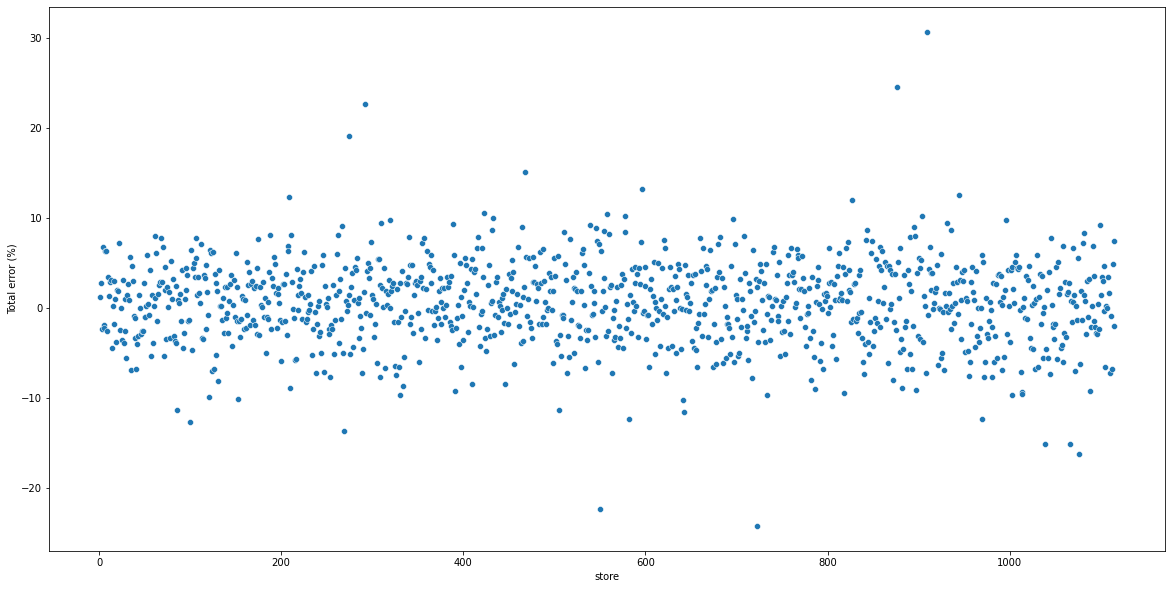

In [104]:
sns.scatterplot( x='store', y='Total error (%)', data=df102 );

In [105]:
# Number of stores with Total error (%) > 10% (absolute)

df102[np.abs( df102['Total error (%)'] ) > 10].shape[0]

27

In [106]:
# They compose a very few percentage of the whole

str( np.round( df102[np.abs( df102['Total error (%)'] ) > 10].shape[0] / 1115 * 100, 2 ) ) + '%'

'2.42%'

## Overall performance

In [107]:
df103 = ( df102.loc[:,['Actual income', 'Predicted income', 'Total error']].sum()
                                                                           .reset_index()
                                                                           .rename( columns={'index': 'Case', 0: 'Values'} ) )

aux_value = np.round( df103.loc[2,'Values'] / df103.loc[0,'Values'] * 100, 2)
df103.loc[:,'Values'] = df103.loc[:,'Values'].map( '${:,.2f}'.format )
aux = pd.DataFrame( {'Case': 'Total error (%)', 'Values': '{}%'.format( aux_value )}, index=[3] )
df103 = pd.concat( [df103, aux] )

In [108]:
df103

,Case,Values
0,Actual income,"$289,571,750.00"
1,Predicted income,"$286,722,368.00"
2,Total error,"$2,849,389.30"
3,Total error (%),0.98%


## Machine Learning performance

In [109]:
df104 = df10.copy()
df104.loc[:,'error'] = df104.loc[:,'sales'] - df104.loc[:,'predictions']
df104.loc[:,'error_rate'] = df104.loc[:,'predictions'] / df104.loc[:,'sales']

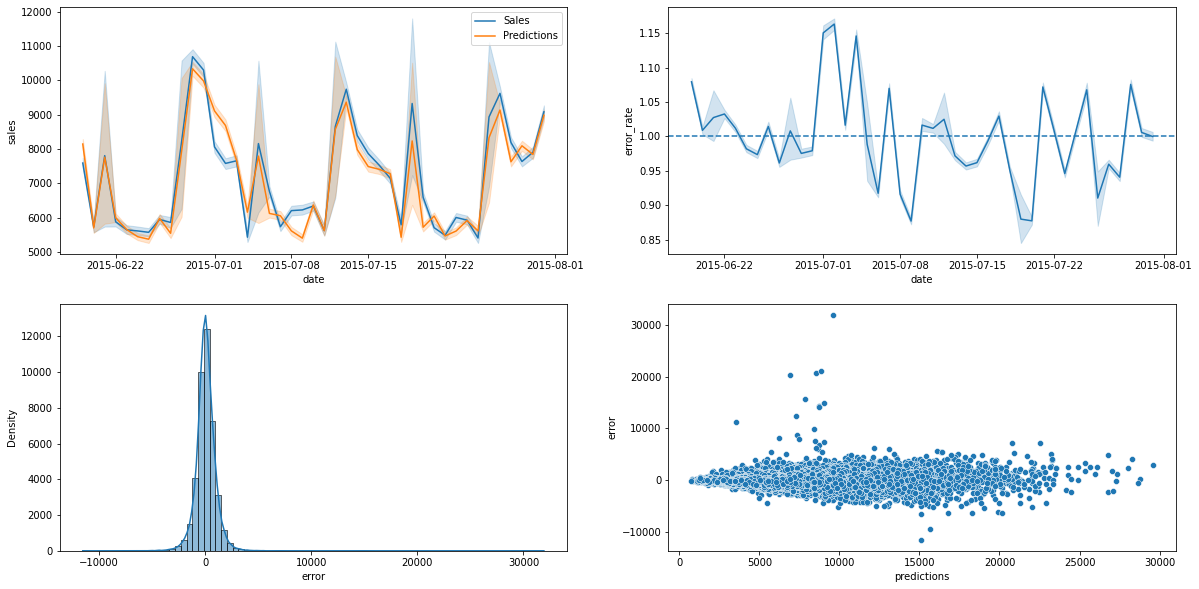

In [110]:
plt.rcParams['figure.figsize'] = 20,10

plt.subplot( 2,2,1 )
sns.lineplot( x='date', y='sales', data=df104, label='Sales' );
sns.lineplot( x='date', y='predictions', data=df104, label='Predictions' );

plt.subplot( 2,2,2 )
sns.lineplot( x='date', y='error_rate', data=df104 );
plt.axhline( 1, linestyle='--' );

plt.subplot( 2,2,3 )
sns.histplot( df104.loc[:,'error'], bins=80, kde=True );
plt.ylabel( 'Density' );

plt.subplot( 2,2,4 )
sns.scatterplot( x='predictions', y='error', data=df104 );

# DEPLOYMENT

## Rossmann Class

**_The script below was used for the deploy on Heroku:_**

In [14]:
import pickle
import inflection
import numpy as np
import pandas as pd
import datetime
import math

class Rossmann( object ):
    def __init__( self ):
        self.home_path = ''
        self.competition_distance_scaler        = pickle.load( open( self.home_path + 'parameters/competition_distance_scaler.pkl', 'rb' ) )
        self.competition_time_month_scaler      = pickle.load( open( self.home_path + 'parameters/competition_time_month_scaler.pkl', 'rb' ) )
        self.promo2_time_week_scaler            = pickle.load( open( self.home_path + 'parameters/promo2_time_week_scaler.pkl', 'rb' ) )
        self.year_scaler                        = pickle.load( open( self.home_path + 'parameters/year_scaler.pkl', 'rb' ) )
        self.store_scaler                       = pickle.load( open( self.home_path + 'parameters/store_scaler.pkl', 'rb' ) )
        self.competition_open_since_year_scaler = pickle.load( open( self.home_path + 'parameters/competition_open_since_year_scaler.pkl', 'rb' ) )
        self.promo2_since_year_scaler           = pickle.load( open( self.home_path + 'parameters/promo2_since_year_scaler.pkl', 'rb' ) )
        self.store_type_encoder                 = pickle.load( open( self.home_path + 'parameters/store_type_encoder.pkl', 'rb' ) )
    
    def data_cleaning( self, df2 ):
        ## Renaming columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list(map( snakecase, cols_old ))
        df2.columns = cols_new

        ## Fixing types 
        df2.loc[:,'date'] = pd.to_datetime( df2.loc[:,'date'] )
        
        ## Filling out NAs
        # competition_distance
        df2.loc[:,'competition_distance'] = df2.loc[:,'competition_distance'].apply(lambda x: 300000 if math.isnan(x) else x)

        # competition_open_since_month
        df2.loc[:,'competition_open_since_month'] = df2.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

        # competition_open_since_year
        df2.loc[:,'competition_open_since_year'] = df2.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

        # promo2_since_week
        df2.loc[:,'promo2_since_week'] = df2.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

        # promo2_since_year
        df2.loc[:,'promo2_since_year'] = df2.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)
              
        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df2.loc[:,'month_map'] = df2.loc[:,'date'].dt.month.map( month_map )
        df2.loc[:,'promo_interval'].fillna( 0, inplace=True )
        df2.loc[:,'is_start_promo2'] =  df2.loc[:,['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'] else 0, axis=1)

        ## Changing types 
        df2.loc[:,'competition_open_since_month'] = df2.loc[:,'competition_open_since_month'].astype( np.int64 )
        df2.loc[:,'competition_open_since_year'] = df2.loc[:,'competition_open_since_year'].astype( np.int64 )
        df2.loc[:,'promo2_since_week'] = df2.loc[:,'promo2_since_week'].astype( np.int64 )
        df2.loc[:,'promo2_since_year'] = df2.loc[:,'promo2_since_year'].astype( np.int64 )
        
        return df2 
    
    
    def feature_engineering( self, df3 ):
        # year
        df3.loc[:,'year'] = df3.loc[:,'date'].dt.year

        # month
        df3.loc[:,'month'] = df3.loc[:,'date'].dt.month

        # day
        df3.loc[:,'day'] = df3.loc[:,'date'].dt.day

        # week of year
        df3['week_of_year'] = df3['date'].dt.isocalendar().week - 1 # Minus 1 since ISO count starts from 1
        df3['week_of_year'] = df3['week_of_year'].astype( np.int64 ) #UInt32 to int64

        # year week
        df3.loc[:,'year_week'] = df3.loc[:,'date'].dt.strftime( '%Y-%W' )

        # competition since
        df3.loc[:,'competition_since'] = df3.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
        # competition time (months)
        df3.loc[:,'competition_time_month'] = ( ( df3.loc[:,'date'] - df3.loc[:,'competition_since'] )/30 ).dt.days
        
        # promo2 since
        df3.loc[:,'promo2_since'] = df3.loc[:,'promo2_since_year'].astype(str) + '-' + df3.loc[:,'promo2_since_week'].astype(str)
        df3.loc[:,'promo2_since'] = df3.loc[:,'promo2_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) )
        # promo2 time (weeks)
        df3.loc[:,'promo2_time_week'] = ( ( df3.loc[:,'date'] - df3.loc[:,'promo2_since'] )/7 ).dt.days
        
        # assortment
        df3.loc[:,'assortment'] = df3.loc[:,'assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended' )

        # state holiday
        df3.loc[:,'state_holiday'] = df3.loc[:,'state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        ## Filtering rows
        df3 = df3.loc[df3.loc[:,'open'] != 0, :]

        ## Selecting columns
        cols_drop = ['open', 'promo_interval', 'month_map']
        df3.drop( columns=cols_drop, inplace=True )

        return df3
    
    
    def data_preparation( self, df6 ):
        ## Rescaling
        df6.loc[:,'competition_distance'] = self.competition_distance_scaler.fit_transform( df6.loc[:,['competition_distance']] )

        df6.loc[:,'competition_time_month'] = self.competition_time_month_scaler.fit_transform( df6.loc[:,['competition_time_month']] )

        df6.loc[:,'promo2_time_week'] = self.promo2_time_week_scaler.fit_transform( df6.loc[:,['promo2_time_week']] )

        df6.loc[:,'year'] = self.year_scaler.fit_transform( df6.loc[:,['year']] )
        
        df6.loc[:,'store'] = self.store_scaler.fit_transform( df6.loc[:,['store']] )

        df6.loc[:,'competition_open_since_year'] = self.competition_open_since_year_scaler.fit_transform( df6.loc[:,['competition_open_since_year']] )

        df6.loc[:,'promo2_since_year'] = self.promo2_since_year_scaler.fit_transform( df6.loc[:,['promo2_since_year']] )

        ## Transformation
        ### Categorical variables encoding
        # state_holiday - One Hot Encoding
        df6 = pd.get_dummies( df6, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df6.loc[:,'store_type'] = self.store_type_encoder.fit_transform( df6.loc[:,'store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 0, 'extra': 1, 'extended': 2}
        df6.loc[:,'assortment'] = df6.loc[:,'assortment'].map( assortment_dict )

        ### Nature transformation
        # day_of_week
        df6.loc[:,'day_of_week_sin'] = df6.loc[:,'day_of_week'].apply( lambda x: np.sin( x*2*np.pi/7 ) )
        df6.loc[:,'day_of_week_cos'] = df6.loc[:,'day_of_week'].apply( lambda x: np.cos( x*2*np.pi/7 ) )

        # month
        df6.loc[:,'month_sin'] = df6.loc[:,'month'].apply( lambda x: np.sin( x*2*np.pi/12 ) )
        df6.loc[:,'month_cos'] = df6.loc[:,'month'].apply( lambda x: np.cos( x*2*np.pi/12 ) )

        # day
        df6.loc[:,'day_sin'] = df6.loc[:,'day'].apply( lambda x: np.sin( x*2*np.pi/30 ) )
        df6.loc[:,'day_cos'] = df6.loc[:,'day'].apply( lambda x: np.cos( x*2*np.pi/30 ) )

        # week_of_year
        df6.loc[:,'week_of_year_sin'] = df6.loc[:,'week_of_year'].apply( lambda x: np.sin( x*2*np.pi/52 ) )
        df6.loc[:,'week_of_year_cos'] = df6.loc[:,'week_of_year'].apply( lambda x: np.cos( x*2*np.pi/52 ) )
        
        # competition_open_since_month
        df6.loc[:,'competition_open_since_month_sin'] = df6.loc[:,'competition_open_since_month'].apply( lambda x: np.sin( x*2*np.pi/12 ) )
        df6.loc[:,'competition_open_since_month_cos'] = df6.loc[:,'competition_open_since_month'].apply( lambda x: np.cos( x*2*np.pi/12 ) )

        # promo2_since_week
        df6.loc[:,'promo2_since_week_sin'] = df6.loc[:,'promo2_since_week'].apply( lambda x: np.sin( x*2*np.pi/52 ) )
        df6.loc[:,'promo2_since_week_cos'] = df6.loc[:,'promo2_since_week'].apply( lambda x: np.cos( x*2*np.pi/52 ) )
        
        cols_selected = [
        'store',
        'promo',
        'store_type',
        'assortment',
        'competition_distance',
        'competition_open_since_year',
        'promo2',
        'promo2_since_year',
        'competition_time_month',
        'promo2_time_week',
        'day_of_week_sin',
        'day_of_week_cos',
        'month_sin',
        'month_cos',
        'day_sin',
        'day_cos',
        'competition_open_since_month_sin',
        'competition_open_since_month_cos',
        'promo2_since_week_sin',
        'promo2_since_week_cos']
        
        return df6.loc[:,cols_selected]
    
    
    def get_prediction( self, model, tester, tester_pipelined ):
        # Prediction
        pred = model.predict( tester_pipelined )
        
        # Add to the original
        tester['prediction'] = np.expm1( pred )
        
        return tester.to_json( orient='records', date_format='iso' )

## API Handler

**_The script below was used for the deploy on Heroku_**

In [ ]:
import os
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# Loading model
model = pickle.load( open( 'model/tuned_xgb_rossmann.pkl', 'rb' ) )

# Initializing API
app = Flask( __name__ )

# API endpoint
@app.route( '/rossmann/predict', methods=['POST'] )    

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # There's data
        if isinstance( test_json, dict ): # Unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # Multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
    
        # Instantiate class
        pipeline = Rossmann()
    
        # Cleaning
        df1 = pipeline.data_cleaning( test_raw )
        # Feature engineering
        df2 = pipeline.feature_engineering( df1 )
        # Preparation
        df3 = pipeline.data_preparation( df2 )
        # Prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
    
        return df_response
        
    
    else: # Empty
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    port = os.environ.get( 'PORT', 5000 )
    app.run( host='0.0.0.0', port=port )

## API Tester

In [76]:
import requests
import json

In [183]:
df_tester = pd.read_csv( '../data/test.csv' )
df_tester.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [122]:
# Not all stores in the training dataset are in the test dataset
len( df_tester.loc[:,'Store'].unique() )

856

In [129]:
# The date span is the same for all of them

aux = df_tester.copy()

aux['Date'] = pd.to_datetime( aux['Date'] )

grp = aux.loc[:, ['Date','Store']].groupby( 'Store' )

# Starts of periods
st = grp.apply( lambda x: x.loc[ x['Date'] - pd.DateOffset( days = 1 ) 
                                 != x['Date'].shift(-1), 'Date' ] ).reset_index( level=1, drop=True )

# Ends of periods
en = grp.apply( lambda x: x.loc[ x['Date'] + pd.DateOffset( days = 1 ) 
                                 != x['Date'].shift(), 'Date' ] ).reset_index( level=1, drop=True )

# Result - concat start / end Dates
res = pd.concat([st, en], axis=1).reset_index()
# Set column names
res.columns = ['Store', 'start', 'end']

res.drop_duplicates( ['start','end'] )

,Store,start,end
0,1,2015-08-01,2015-09-17


In [184]:
df_tester = pd.merge( df_tester, df_stores_raw, how='left', on='Store' )

df_tester = df_tester.loc[df_tester.loc[:,'Store'] == 22,:]
df_tester = df_tester.loc[df_tester.loc[:,'Open'] != 0,:]

# Fixing df_tester problems not contemplated by Rossmann.data_cleaning
df_tester = df_tester.drop( columns='Id', axis=1 )
df_tester = df_tester.loc[~df_tester.loc[:,'Open'].isna(),:]

In [185]:
# API call
#url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-store-sales-forecast.herokuapp.com/rossmann/predict'
header = { 'Content-type': 'application/json' }
data = json.dumps( df_tester.to_dict( orient='records' ) )

r = requests.post( url, data=data, headers=header )
print( 'Status code {}'.format( r.status_code ) )

Status code 200


In [186]:
df_response = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [187]:
df_response.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_start_promo2,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,prediction
0,22,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,37,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-28T00:00:00.000Z,172,4643.502441
1,22,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,37,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-28T00:00:00.000Z,172,5224.351562
2,22,2,2015-09-15T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,15,37,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-28T00:00:00.000Z,172,5303.016113
3,22,1,2015-09-14T00:00:00.000Z,1.0,1,regular_day,1,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,14,37,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-28T00:00:00.000Z,172,5993.215820
4,22,6,2015-09-12T00:00:00.000Z,1.0,0,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,12,36,2015-36,2015-09-01T00:00:00.000Z,0,2012-05-28T00:00:00.000Z,171,2646.739746


In [191]:
aux = df_response.loc[:,['store','prediction']].groupby( 'store' ).sum().reset_index()

print( 'Store #{} will sell ${:,.2f} in the next 6 weeks.'.format( 
            aux.loc[0,'store'], 
            aux.loc[0,'prediction'] ) )

Store #22 will sell $162,550.90 in the next 6 weeks.


## Rossmann Telegram bot

In [67]:
import pandas as pd
import requests
import json
from flask import Flask, request, Response

# constants
TOKEN = '<token>'

# getMe
# https://api.telegram.org/<token>/getMe

# getUpdates
# https://api.telegram.org/<token>/getUpdates

# sendMessage
# https://api.telegram.org/<token>/sendMessage?chat_id=<ID>&text=<MSSG>

# setWebhook
# https://api.telegram.org/<token>/setWebhook?url=<URL>

###### Functions ######

def parse_message( message ):
    chat_id = message['message']['chat']['id']
    store_id = message['message']['text']
    
    store_id = store_id.replace( '/',' ' )
    
    try:
        store_id = int( store_id )
    except ValueError:
        store_id = 'error'
    
    return chat_id, store_id


def send_message( chat_id, text ):
    url = 'https://api.telegram.org/bot{}/sendMessage?chat_id={}'.format( TOKEN, chat_id )
    r = requests.post( url, json={'text': text} )
    f'Status code: {r.status_code}'
    
    return None
    
    
def load_dataset( store_id ):
    df_tester = pd.read_csv( '../data/test.csv' )
    df_stores_raw = pd.read_csv( '../data/store.csv', low_memory=False )
    df_tester = pd.merge( df_tester, df_stores_raw, how='left', on='Store' )

    df_tester = df_tester.loc[df_tester.loc[:,'Store'] == store_id,:]
    
    if not df_tester.empty:    
        df_tester = df_tester.loc[df_tester.loc[:,'Open'] != 0,:]

        # Fixing df_tester problems not contemplated by Rossmann.data_cleaning
        df_tester = df_tester.drop( columns='Id', axis=1 )
        df_tester = df_tester.loc[~df_tester.loc[:,'Open'].isna(),:]
    
        data = json.dumps( df_tester.to_dict( orient='records' ) )
    
    else:
        data = 'error'
    
    
    return data
    
    
def predict( data ):
    # API call
    url = 'https://rossmann-store-sales-forecast.herokuapp.com/rossmann/predict'
    header = { 'Content-type': 'application/json' }

    r = requests.post( url, data=data, headers=header )
    print( 'Status code {}'.format( r.status_code ) )

    df_response = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

    return df_response


######################################

app = Flask( __name__ )

@app.route( '/', methods=['GET', 'POST'] )
def index():
    if request.method == 'POST':
        message = request.get_json()
        chat_id, store_id = parse_message( message )
        
        if store_id != 'error':
            # load data
            data = load_dataset( store_id )
                
            if data != 'error':
                # predict
                df1 = predict( data )
                # sum up
                df2 = df1.loc[:,['store','prediction']].groupby( 'store' ).sum().reset_index()
                mssg = 'Store #{} will sell ${:,.2f} in the next 6 weeks.'.format(df2.loc[0,'store'], df2.loc[0,'prediction'] )
                # send message
                send_message( chat_id, mssg )
                
                return Response( 'Ok', status=200 ) 
            
            else:
                send_message( chat_id, 'Store not available' )
                return Response( 'Ok', status=200 )
        else:
            send_message( chat_id, 'Not a valid Store ID' )
            return Response( 'Ok', status=200 )
        
    else:
        return '<h1> Rossmann Telegram Bot awaiting call. </h1>'


if __name__ == '__main__':
    app.run( host='127.0.0.1', port=5000 )